In [2]:
from sklearn.model_selection import cross_val_score, train_test_split
from scipy.stats import linregress
from tqdm import tqdm

import glob
import lightgbm as lgb
import numpy as np
import optuna as op
import os
import pandas as pd

op.logging.set_verbosity(op.logging.WARNING)

c:\Users\charl\Desktop\Git\tep-research\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
import os
os.listdir('../')

['.git', '.gitignore', '.venv', 'data', 'notebooks', 'README.md']

In [64]:
sim_season = 2024
gender = 'M'
sample_size = 1000
sub_df = pd.read_csv(f'../data/kaggle/output/madness-2024-sub-proba/{sim_season}/submission.csv')

df_teams = pd.read_csv(f'../data/kaggle/march-machine-learning-mania-2024/{gender}Teams.csv')
df_teams = df_teams[['TeamID','TeamName']].copy()
df_seeds = pd.read_csv(f'../data/kaggle/march-machine-learning-mania-2024/{gender}NCAATourneySeeds.csv')
df_seeds = df_seeds[df_seeds.Season==sim_season].drop(columns=['Season']).copy()
df_seeds = pd.merge(df_seeds,df_teams, on=['TeamID'])
df_seeds['Seed'] = df_seeds['Seed'].str[0:3]

In [65]:
idxs = np.random.randint(1,100000+1, sample_size)
sub_df = sub_df[sub_df.Bracket.isin(idxs)].copy()

In [66]:
m_sub = sub_df[sub_df.Tournament==gender].drop(columns=['RowId','Tournament']).copy()
m_sub_grouped = m_sub.groupby('Slot')['Team'].value_counts().reset_index(name='Count')
m_sub_grouped['Count'] = m_sub_grouped['Count'] / sample_size
m_sub_grouped['Round'] = m_sub_grouped['Slot'].str[1].astype(int)
m_sub_grouped['Region'] = m_sub_grouped['Slot'].str[2]
m_sub_grouped = pd.merge(m_sub_grouped, df_seeds, left_on=['Team'], right_on=['Seed'])

In [8]:
from sklearn.linear_model import LinearRegression
import numpy as np

physics_scores = np.array([15, 12, 8, 8, 7, 7, 7, 6, 5, 3]).reshape(-1, 1)
history_scores = np.array([10, 25, 17, 11, 13, 17, 20, 13, 9, 15]).reshape(-1, 1)

reg = LinearRegression().fit(physics_scores, history_scores)

# Physics score of the student in question
physics_score = np.array([[10]])  # Using the provided physics score

# Predict the history score for the given physics score
history_score = reg.predict(physics_score)

# Print the predicted history score rounded to one decimal place
print(round(history_score[0][0], 1))


15.5


In [18]:
from sklearn.linear_model import LinearRegression
# Important Observation: The prices per square foot form an approximately linear function for the features quantified in Charlie's table. For the purposes of prediction, you need to figure out this linear function.


# The first line contains  space-separated integers,  (the number of observed features) and  (the number of rows/houses for which Charlie has noted both the features and price per square foot).
F, N = 2, 7
data = [
'0.18 0.89 109.85',
'1.0 0.26 155.72',
'0.92 0.11 137.66',
'0.07 0.37 76.17',
'0.85 0.16 139.75',
'0.99 0.41 162.6',
'0.87 0.47 151.77',
]
X_train = []
y_train = []
for i in range(N):
    row = list(map(float,data[i].split(' ')))
    x = row
    y = [row.pop()]
    X_train.append(x)
    y_train.append(y)
X_train

[[0.18, 0.89],
 [1.0, 0.26],
 [0.92, 0.11],
 [0.07, 0.37],
 [0.85, 0.16],
 [0.99, 0.41],
 [0.87, 0.47]]

In [25]:
reg = LinearRegression().fit(np.array(X_train), np.array(y_train))

T = 4
test_data = [
    '0.49 0.18',
    '0.57 0.83',
    '0.56 0.64',
    '0.76 0.18',
]
for i in range(T):
    row = list(map(float, test_data[i].split(' ')))
    print(round(reg.predict(np.array([row]))[0][0], 2))

105.21
142.67
132.94
129.7


In [69]:
m_sub_grouped[((m_sub_grouped.Region=='W')&(m_sub_grouped.Round < 4))]

,Slot,Team,Count,Round,Region,Seed,TeamID,TeamName
0,R1W1,W01,0.991,1,W,W01,1163,Connecticut
1,R1W2,W02,0.991,1,W,W02,1235,Iowa St
2,R1W3,W03,0.991,1,W,W03,1228,Illinois
3,R1W4,W04,0.991,1,W,W04,1120,Auburn
4,R1W5,W05,0.691,1,W,W05,1361,San Diego St
5,R1W5,W12,0.300,1,W,W12,1412,UAB
6,R1W6,W06,0.603,1,W,W06,1140,BYU
7,R1W6,W11,0.388,1,W,W11,1182,Duquesne
8,R1W7,W07,0.607,1,W,W07,1450,Washington St
9,R1W7,W10,0.384,1,W,W10,1179,Drake


# Load the data!

In [220]:
DATA_PATH = '../data/kaggle/march-machine-learning-mania-2024/'
CSV = {}

for path in glob.glob(DATA_PATH + "/*.csv"):
    CSV[os.path.basename(path).split('.')[0]] = pd.read_csv(path, encoding='cp1252')


In [222]:
CSV['2024_tourney_seeds'].Seed.unique()

array(['W01', 'W02', 'W03', 'W04', 'W05', 'W06', 'W07', 'W08', 'W09',
       'W10', 'W11', 'W12', 'W13', 'W14', 'W15', 'W16', 'X01', 'X02',
       'X03', 'X04', 'X05', 'X06', 'X07', 'X08', 'X09', 'X10', 'X11',
       'X12', 'X13', 'X14', 'X15', 'X16', 'Y01', 'Y02', 'Y03', 'Y04',
       'Y05', 'Y06', 'Y07', 'Y08', 'Y09', 'Y10', 'Y11', 'Y12', 'Y13',
       'Y14', 'Y15', 'Y16', 'Z01', 'Z02', 'Z03', 'Z04', 'Z05', 'Z06',
       'Z07', 'Z08', 'Z09', 'Z10', 'Z11', 'Z12', 'Z13', 'Z14', 'Z15',
       'Z16'], dtype=object)

In [3]:
import argparse
import datetime

import numpy as np
import pandas as pd
import os
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from scipy.interpolate import UnivariateSpline
import statsmodels.api as sm

def prepare_data(df):
    dfswap = df[['Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT',
                 'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF',
                 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']]

    dfswap.loc[df['WLoc'] == 'H', 'WLoc'] = 'A'
    dfswap.loc[df['WLoc'] == 'A', 'WLoc'] = 'H'
    df.columns.values[6] = 'location'
    dfswap.columns.values[6] = 'location'

    df.columns = [x.replace('W', 'T1_').replace('L', 'T2_') for x in list(df.columns)]
    dfswap.columns = [x.replace('L', 'T1_').replace('W', 'T2_') for x in list(dfswap.columns)]

    output = pd.concat([df, dfswap]).reset_index(drop=True)
    output.loc[output.location == 'N', 'location'] = '0'
    output.loc[output.location == 'H', 'location'] = '1'
    output.loc[output.location == 'A', 'location'] = '-1'
    output.location = output.location.astype(int)

    output['PointDiff'] = output['T1_Score'] - output['T2_Score']
    output['PointDiffAgainst'] = output['T2_Score'] - output['T1_Score']
    return output

def build_season_statistics(regular_data):
    # Handle Avg Boxscore calculations
    boxscore_cols = [
        'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_OR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_PF',
        'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_OR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk',
        'PointDiff','PointDiffAgainst']

    funcs = [np.mean]

    season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs).reset_index()
    season_statistics.columns = ['_'.join(col).strip() for col in season_statistics.columns.values]
    season_statistics_T1 = season_statistics.copy()
    season_statistics_T2 = season_statistics.copy()

    # Column renaming
    season_statistics_T1.columns = ["T1_" + x.replace("T1_", "off_").replace("T2_", "def_") for x in list(season_statistics_T1.columns)]
    season_statistics_T2.columns = ["T2_" + x.replace("T1_", "off_").replace("T2_", "def_") for x in list(season_statistics_T2.columns)]
    season_statistics_T1.columns.values[0] = "Season"
    season_statistics_T2.columns.values[0] = "Season"
    season_statistics_T1.columns.values[1] = "T1_TeamID"
    season_statistics_T2.columns.values[1] = "T2_TeamID"
    return season_statistics_T1, season_statistics_T2

def build_score_attrs(regular_data):
    season_score_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[['T1_Score', 'T2_Score']].agg(['mean','min', 'max', 'std']).reset_index()
    season_score_statistics.columns = ['_'.join(col).strip() for col in season_score_statistics.columns.values]
    season_score_statistics_T1 = season_score_statistics.copy()
    season_score_statistics_T2 = season_score_statistics.copy()

    # Column renaming
    season_score_statistics_T1.columns = ["T1_" + x.replace("T1_", "off_").replace("T2_", "def_") for x in list(season_score_statistics_T1.columns)]
    season_score_statistics_T2.columns = ["T2_" + x.replace("T1_", "off_").replace("T2_", "def_") for x in list(season_score_statistics_T2.columns)]
    season_score_statistics_T1.columns.values[0] = "Season"
    season_score_statistics_T2.columns.values[0] = "Season"
    season_score_statistics_T1.columns.values[1] = "T1_TeamID"
    season_score_statistics_T2.columns.values[1] = "T2_TeamID"
    return season_score_statistics_T1, season_score_statistics_T2

def build_win_perc(regular_data):
    last14days_stats_T1 = regular_data.reset_index(drop=True)
    last14days_stats_T1['win'] = np.where(last14days_stats_T1['PointDiff'] > 0, 1, 0)
    last14days_stats_T1 = last14days_stats_T1.groupby(['Season', 'T1_TeamID'])['win'].mean().reset_index(name='T1_win_ratio')
    last14days_stats_T2 = regular_data.reset_index(drop=True)
    last14days_stats_T2['win'] = np.where(last14days_stats_T2['PointDiff'] < 0, 1, 0)
    last14days_stats_T2 = last14days_stats_T2.groupby(['Season', 'T2_TeamID'])['win'].mean().reset_index(name='T2_win_ratio')
    return last14days_stats_T1, last14days_stats_T2

def build_last_14_stats(regular_data):
    # Adds last 14 day stats
    last14days_stats_T1 = regular_data.loc[regular_data.DayNum > 118].reset_index(drop=True)
    last14days_stats_T1['win'] = np.where(last14days_stats_T1['PointDiff'] > 0, 1, 0)
    last14days_stats_T1 = last14days_stats_T1.groupby(['Season', 'T1_TeamID'])['win'].mean().reset_index(name='T1_win_ratio_14d')
    last14days_stats_T2 = regular_data.loc[regular_data.DayNum > 118].reset_index(drop=True)
    last14days_stats_T2['win'] = np.where(last14days_stats_T2['PointDiff'] < 0, 1, 0)
    last14days_stats_T2 = last14days_stats_T2.groupby(['Season', 'T2_TeamID'])['win'].mean().reset_index(name='T2_win_ratio_14d')
    return last14days_stats_T1, last14days_stats_T2

def build_seeds(seeds):
    # Adds Seeds
    seeds['seed'] = seeds['Seed'].apply(lambda x: int(x[1:3]))
    seeds_T1 = seeds[['Season', 'TeamID', 'seed']].copy()
    seeds_T2 = seeds[['Season', 'TeamID', 'seed']].copy()
    seeds_T1.columns = ['Season', 'T1_TeamID', 'T1_seed']
    seeds_T2.columns = ['Season', 'T2_TeamID', 'T2_seed']
    return seeds_T1, seeds_T2

def team_quality(season, regular_season_effects):
    formula = 'win~-1+T1_TeamID+T2_TeamID'
    glm = sm.GLM.from_formula(formula=formula,
                              data=regular_season_effects.loc[regular_season_effects.Season == season, :],
                              family=sm.families.Binomial()).fit()

    quality = pd.DataFrame(glm.params).reset_index()
    quality.columns = ['TeamID', 'quality']
    quality['Season'] = season
    # quality['quality'] = np.exp(quality['quality'])
    quality = quality.loc[quality.TeamID.str.contains('T1_')].reset_index(drop=True)
    quality['TeamID'] = quality['TeamID'].apply(lambda x: x[10:14]).astype(int)
    return quality

def build_quality(regular_season_effects, seeds, sim_season):
    # Create effects dataframe to feed to quality model

    regular_season_effects['T1_TeamID'] = regular_season_effects['T1_TeamID'].astype(str)
    regular_season_effects['T2_TeamID'] = regular_season_effects['T2_TeamID'].astype(str)
    regular_season_effects['win'] = np.where(regular_season_effects['PointDiff'] > 0, 1, 0)
    march_madness = pd.merge(seeds[['Season', 'TeamID']], seeds[['Season', 'TeamID']], on='Season')
    march_madness.columns = ['Season', 'T1_TeamID', 'T2_TeamID']
    march_madness.T1_TeamID = march_madness.T1_TeamID.astype(str)
    march_madness.T2_TeamID = march_madness.T2_TeamID.astype(str)
    regular_season_effects = pd.merge(regular_season_effects, march_madness, on=['Season', 'T1_TeamID', 'T2_TeamID'])

    seasons = [season for season in list(range(2003, sim_season + 1)) if season != 2020]
    glm_quality = pd.concat([team_quality(season, regular_season_effects) for season in seasons]).reset_index(drop=True)

    glm_quality_T1 = glm_quality.copy()
    glm_quality_T2 = glm_quality.copy()
    glm_quality_T1.columns = ['T1_TeamID', 'T1_quality', 'Season']
    glm_quality_T2.columns = ['T2_TeamID', 'T2_quality', 'Season']
    return glm_quality_T1, glm_quality_T2

def generate_submission_file(season):
    submission = []
    for gender in ['M','W']:
        subs = []
        teams=pd.read_csv(DATA_PATH + f"{gender}Teams.csv")
        teamids = list(teams.TeamID.unique())
        teamids = sorted(teamids)
        for low_team_id in teamids:
            for high_team_id in teamids:
                subs.append(f"{season}_{low_team_id}_{high_team_id}")
        sub = pd.DataFrame({'ID':subs})
        sub['Pred'] = 0.5
        sub['Tournament'] = gender
        submission.append(sub)
    return pd.concat(submission, ignore_index=True)

def make_features(
        sim_season,
        season_statistics_T1,
        season_statistics_T2,
        season_score_statistics_T1,
        season_score_statistics_T2,
        last14days_stats_T1,
        last14days_stats_T2,
        wp_stats_T1,
        wp_stats_T2,
        seeds_T1,
        seeds_T2,
        glm_quality_T1=None,
        glm_quality_T2=None,
        tourney_data = None,
):
    # Merge regular season stats to tourney data
    if tourney_data is not None:
        tourney_data = tourney_data[['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID', 'T2_Score']]
        is_test = False
    else:
        tourney_data = generate_submission_file(sim_season)
        tourney_data['Season'] = tourney_data['ID'].apply(lambda x: int(x.split('_')[0]))
        tourney_data["T1_TeamID"] = tourney_data['ID'].apply(lambda x: int(x.split('_')[1]))
        tourney_data["T2_TeamID"] = tourney_data['ID'].apply(lambda x: int(x.split('_')[2]))
        is_test = True
    tourney_data = pd.merge(tourney_data, season_statistics_T1, on=['Season', 'T1_TeamID'], how='left')
    tourney_data = pd.merge(tourney_data, season_statistics_T2, on=['Season', 'T2_TeamID'], how='left')

    tourney_data = pd.merge(tourney_data, season_score_statistics_T1, on=['Season', 'T1_TeamID'], how='left')
    tourney_data = pd.merge(tourney_data, season_score_statistics_T2, on=['Season', 'T2_TeamID'], how='left')

    # Merge last 14 day stats to tourney data
    tourney_data = pd.merge(tourney_data, last14days_stats_T1, on=['Season', 'T1_TeamID'], how='left')
    tourney_data = pd.merge(tourney_data, last14days_stats_T2, on=['Season', 'T2_TeamID'], how='left')

    # Merge win percentage stats to tourney data
    tourney_data = pd.merge(tourney_data, wp_stats_T1, on=['Season', 'T1_TeamID'], how='left')
    tourney_data = pd.merge(tourney_data, wp_stats_T2, on=['Season', 'T2_TeamID'], how='left')

    # Merge seeds to tourney data
    tourney_data = pd.merge(tourney_data, seeds_T1, on=['Season', 'T1_TeamID'], how='left')
    tourney_data = pd.merge(tourney_data, seeds_T2, on=['Season', 'T2_TeamID'], how='left')

    # Merge quality to tourney data (adds optional case for adding this feature cause it takes a bit to compute)
    if glm_quality_T1 is not None and glm_quality_T2 is not None:
        tourney_data = pd.merge(tourney_data, glm_quality_T1, on=['Season', 'T1_TeamID'], how='left')
        tourney_data = pd.merge(tourney_data, glm_quality_T2, on=['Season', 'T2_TeamID'], how='left')
    else:
        tourney_data['T1_quality'] = 0.001
        tourney_data['T2_quality'] = 0.001

    # Create seed diff feature and drop seeds
    tourney_data["Seed_diff"] = tourney_data["T1_seed"] - tourney_data["T2_seed"]
    if not is_test:
        # Create the tourney point diff incase we want to use this as the target again
        tourney_data['PointDiff'] = tourney_data['T1_Score'] - tourney_data['T2_Score']
        tourney_data = tourney_data.sort_values(['Season', 'DayNum'])

    return tourney_data


def preprocess(sim_season):
    ## Import data
    tourney_results = pd.concat([
        pd.read_csv(DATA_PATH + "MNCAATourneyDetailedResults.csv"),
        pd.read_csv(DATA_PATH + "WNCAATourneyDetailedResults.csv"),
    ], ignore_index=True)

    new_seeds = pd.read_csv(DATA_PATH + "2024_tourney_seeds.csv")
    new_seeds['Season'] = 2024
    new_seeds = new_seeds.drop(columns='Tournament')
    seeds = pd.concat([
        pd.read_csv(DATA_PATH + "MNCAATourneySeeds.csv"),
        pd.read_csv(DATA_PATH + "WNCAATourneySeeds.csv"),
        new_seeds
    ], ignore_index=True)

    regular_results = pd.concat([
        pd.read_csv(DATA_PATH + "MRegularSeasonDetailedResults.csv"),
        pd.read_csv(DATA_PATH + "WRegularSeasonDetailedResults.csv"),
    ], ignore_index=True)

    regular_data = prepare_data(regular_results)
    tourney_data = prepare_data(tourney_results)

    # Avoid leakage for previous seasons
    regular_data = regular_data.loc[regular_data.Season <= sim_season].copy()
    tourney_data = tourney_data.loc[tourney_data.Season < sim_season].copy()

    ## Logic check:
    print('=' * 40)
    print('Experiment: madness-2024-sub')
    print(f'Sim Season: {sim_season}')
    print(f'Building data for {sim_season} pre tourney state...')
    print(f'   - data up to {regular_data.Season.max()} regular season')
    print(f'   - data up to {tourney_data.Season.max()} post season')
    print(f'   - Predicting {tourney_data.Season.max()+1} post season')
    print('=' * 40)

    # Handle Avg Boxscore calculations
    season_statistics_T1, season_statistics_T2 = build_season_statistics(regular_data)
    season_score_statistics_T1, season_score_statistics_T2 = build_score_attrs(regular_data)

    last14days_stats_T1, last14days_stats_T2 = build_last_14_stats(regular_data)

    wp_stats_T1, wp_stats_T2 = build_win_perc(regular_data)

    seeds_T1, seeds_T2 = build_seeds(seeds)

    regular_season_effects = regular_data[['Season', 'T1_TeamID', 'T2_TeamID', 'PointDiff']].copy()
    glm_quality_T1, glm_quality_T2 = build_quality(regular_season_effects, seeds, sim_season)
    #glm_quality_T1, glm_quality_T2 = None, None
    tourney_data = make_features(
        sim_season,
        season_statistics_T1,
        season_statistics_T2,
        season_score_statistics_T1,
        season_score_statistics_T2,
        last14days_stats_T1,
        last14days_stats_T2,
        wp_stats_T1,
        wp_stats_T2,
        seeds_T1,
        seeds_T2,
        glm_quality_T1,
        glm_quality_T2,
        tourney_data=tourney_data,
    )
    sub = make_features(
        sim_season,
        season_statistics_T1,
        season_statistics_T2,
        season_score_statistics_T1,
        season_score_statistics_T2,
        last14days_stats_T1,
        last14days_stats_T2,
        wp_stats_T1,
        wp_stats_T2,
        seeds_T1,
        seeds_T2,
        glm_quality_T1,
        glm_quality_T2,
        tourney_data=None,
    )
    stat_cols = [i for i in tourney_data.columns for j in ['_min', '_max', '_std', '_mean'] if j in i]
    features = [
        'Season',
        #'DayNum',
        'T1_TeamID',
        #'T1_Score',
        'T2_TeamID',
        #'T2_Score',
        'T1_win_ratio_14d',
        'T2_win_ratio_14d',
        'T1_win_ratio',
        'T2_win_ratio',
        'T1_quality',
        'T2_quality',
        'T1_seed',
        'T2_seed',
        'Seed_diff'
    ] + stat_cols
    return tourney_data, sub, features
tourney_data, sub, features = preprocess(2023)

Experiment: madness-2024-sub
Sim Season: 2023
Building data for 2023 pre tourney state...
   - data up to 2023 regular season
   - data up to 2022 post season
   - Predicting 2023 post season


C:\Users\charl\AppData\Local\Temp\ipykernel_20164\1217522197.py:45: FutureWarning: The provided callable <function mean at 0x000002DE5523B250> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs).reset_index()
c:\Users\charl\Desktop\Git\tep-research\.venv\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
c:\Users\charl\Desktop\Git\tep-research\.venv\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
c:\Users\charl\Desktop\Git\tep-research\.venv\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
c:\Users\charl\Desktop\Git\tep-research\.venv\lib\site-packages\statsmodels\

In [118]:
target = [
    'T1_Score'
]
metadata = ['Season', 'T1_TeamID', 'T2_TeamID', 'T1_seed', 'T2_seed', 'T1_Pred',"T1_Pred_Min","T1_Pred_Max",
       'T2_Pred',"T2_Pred_Min","T2_Pred_Max", 'Seed_diff', 'T1_quality', 'T2_quality', 'T1_off_Score_min',
       'T1_off_Score_mean', 'T1_off_Score_max', 'T1_off_Score_std',
       'T1_PointDiff_mean']

tourney_data = tourney_data.reset_index(drop=True)

X, y = tourney_data[features].copy(), tourney_data[target].copy()

avg = tourney_data[target].values.mean()
std = tourney_data[target].values.std()

upper_bound = int(avg + std *3)
lower_bound = int(avg - std *3)
print(f'Target Values from {round(lower_bound)} - {round(upper_bound)}')
import optuna
def cauchyobj(preds, dtrain):
    labels = dtrain.get_label()
    c = 5000
    x =  preds-labels
    grad = x / (x**2/c**2+1)
    hess = -c**2*(x**2-c**2)/(x**2+c**2)**2
    return grad, hess

Target Values from 29 - 107


In [5]:


def objective(trial, X, y):
    params = {
        'eval_metric': 'mae',
        'booster': 'gbtree',
        'alpha': trial.suggest_float('alpha', 1e-5, 0.1, log=True),
        'lambda': trial.suggest_float('lambda', 1e-5, 0.1, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4,0.1, log=True),
        'gamma': trial.suggest_int('gamma', 0, 30),
        'subsample': trial.suggest_float('subsample', 0.1, 0.8),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0, 1),
        'min_child_weight': trial.suggest_int('min_child_weight', 5, 100),
        'max_depth': trial.suggest_int('max_depth', 2, 20),
        'num_parallel_tree': trial.suggest_int('num_parallel_tree', 5, 31),
        'verbosity': 0
    }
    dtrain = xgb.DMatrix(X, label=y)
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "test-mae")
    history = xgb.cv(
        params,
        dtrain,
        nfold=5,
        obj=cauchyobj,
        early_stopping_rounds=25,
        verbose_eval=500,
        num_boost_round=4000, 
        callbacks=[pruning_callback]
    )
    return history["test-mae-mean"].values[-1]


def study(X, y, n_trials):
    pruner = optuna.pruners.MedianPruner(n_warmup_steps=5)
    s = op.create_study(pruner=pruner,direction='minimize')
    s.optimize(lambda trial: objective(trial, X, y), n_trials=n_trials, n_jobs=-1, show_progress_bar=True)

    return s

s = study(X, y, n_trials=10)
best_trial = s.best_trial
best_trial.params

  0%|          | 0/10 [00:00<?, ?it/s]

[0]	train-mae:65.83828+0.06517	test-mae:65.83728+0.27051
[0]	train-mae:68.18550+0.08544	test-mae:68.18556+0.34256
[0]	train-mae:68.30716+0.06822	test-mae:68.30710+0.27295
[0]	train-mae:68.27411+0.06819	test-mae:68.27405+0.27295
[0]	train-mae:68.31231+0.10498	test-mae:68.31214+0.41973
[0]	train-mae:65.54686+0.08247	test-mae:65.54663+0.34488
[0]	train-mae:62.65342+0.06083	test-mae:62.65422+0.26822
[0]	train-mae:68.12753+0.08010	test-mae:68.12735+0.32126
[0]	train-mae:61.69286+0.07446	test-mae:61.68820+0.33040
[0]	train-mae:68.25811+0.06817	test-mae:68.25802+0.27287
[435]	train-mae:7.47345+0.04959	test-mae:8.18141+0.18200


Best trial: 5. Best value: 8.1804:  10%|█         | 1/10 [02:55<26:23, 175.96s/it]

[104]	train-mae:6.98470+0.04731	test-mae:8.21026+0.19987


Best trial: 5. Best value: 8.1804:  20%|██        | 2/10 [04:29<16:57, 127.20s/it]

[75]	train-mae:3.79496+0.03985	test-mae:8.24398+0.13398


Best trial: 5. Best value: 8.1804:  30%|███       | 3/10 [04:31<08:11, 70.22s/it] 

[500]	train-mae:24.54858+0.02739	test-mae:24.56242+0.30548
[500]	train-mae:59.85549+0.05976	test-mae:59.85549+0.26058
[500]	train-mae:46.96633+0.04668	test-mae:46.96608+0.24557
[500]	train-mae:62.16779+0.09556	test-mae:62.16785+0.41411
[1000]	train-mae:10.88179+0.03599	test-mae:11.07027+0.28434
[500]	train-mae:6.84344+0.04081	test-mae:8.44918+0.14121
[1000]	train-mae:52.45004+0.05244	test-mae:52.45070+0.25027
[566]	train-mae:6.69894+0.04306	test-mae:8.44712+0.14159


Best trial: 5. Best value: 8.1804:  40%|████      | 4/10 [13:03<24:27, 244.61s/it]

[500]	train-mae:16.53421+0.02824	test-mae:16.62554+0.31429
[1500]	train-mae:8.27100+0.03596	test-mae:8.65764+0.18796
[1000]	train-mae:32.31771+0.03201	test-mae:32.31735+0.22881
[1000]	train-mae:56.57628+0.08676	test-mae:56.57654+0.40900
[1500]	train-mae:45.96118+0.04591	test-mae:45.96272+0.24210
[2000]	train-mae:7.79945+0.03311	test-mae:8.31632+0.14626
[1500]	train-mae:22.34102+0.02128	test-mae:22.35725+0.22590
[2000]	train-mae:40.27542+0.04031	test-mae:40.27811+0.23506
[1500]	train-mae:51.48792+0.07898	test-mae:51.48841+0.40383
[2500]	train-mae:7.62896+0.03298	test-mae:8.25566+0.13800
[1000]	train-mae:8.30025+0.03894	test-mae:8.86551+0.15012
[2500]	train-mae:35.29522+0.03468	test-mae:35.29897+0.22810
[3000]	train-mae:7.50828+0.03294	test-mae:8.24059+0.13758
[2000]	train-mae:15.83749+0.01876	test-mae:15.90881+0.23885
[500]	train-mae:41.77165+0.04143	test-mae:41.76269+0.23805
[2000]	train-mae:46.85731+0.07165	test-mae:46.85781+0.39915
[3500]	train-mae:7.40040+0.03185	test-mae:8.23386+0.

Best trial: 5. Best value: 8.1804:  90%|█████████ | 9/10 [32:35<02:35, 155.59s/it]

[1500]	train-mae:7.45239+0.04320	test-mae:8.29649+0.15664
[2000]	train-mae:7.15785+0.04558	test-mae:8.22377+0.17279
[2500]	train-mae:6.92808+0.04445	test-mae:8.20274+0.17928
[2860]	train-mae:6.77727+0.04370	test-mae:8.19808+0.18031


Best trial: 5. Best value: 8.1804: 100%|██████████| 10/10 [35:54<00:00, 215.40s/it]


{'alpha': 1.6021346773224588e-05,
 'lambda': 0.023000143462307127,
 'learning_rate': 0.03640840432583381,
 'gamma': 22,
 'subsample': 0.5232601551969178,
 'colsample_bytree': 0.737619688988669,
 'min_child_weight': 85,
 'max_depth': 2,
 'num_parallel_tree': 11}

In [ ]:
{'alpha': 1.6021346773224588e-05,
 'lambda': 0.023000143462307127,
 'learning_rate': 0.03640840432583381,
 'gamma': 22,
 'subsample': 0.5232601551969178,
 'colsample_bytree': 0.737619688988669,
 'min_child_weight': 85,
 'max_depth': 2,
 'num_parallel_tree': 11}

In [119]:
repeat_cv = 2

param = {
    'alpha': 1.6021346773224588e-05,
    'lambda': 0.023000143462307127,
    'learning_rate': 0.03640840432583381,
    'gamma': 22,
    'subsample': 0.5232601551969178,
    'colsample_bytree': 0.737619688988669,
    'min_child_weight': 85,
    'max_depth': 3,
    'num_parallel_tree': 11
 }
# param['objective'] = 'reg:linear'
param['eval_metric'] = 'mae'
param['booster'] = 'gbtree'
param['silent'] = 1
X = X.values
y=y.values
dtrain = xgb.DMatrix(X, label = y)

xgb_cv = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    xgb_cv.append(
        xgb.cv(
            params=param,
            dtrain=dtrain,
            obj=cauchyobj,
            num_boost_round=3000,
            folds=KFold(n_splits=5, shuffle=True, random_state=i),
            early_stopping_rounds=25,
            verbose_eval=50
        )
    )

iteration_counts = [np.argmin(x['test-mae-mean'].values) for x in xgb_cv]
val_mae = [np.min(x['test-mae-mean'].values) for x in xgb_cv]
print(f"Avg CV validation MAE: {np.array(val_mae).mean()}")



Fold repeater 0
[0]	train-mae:65.83791+0.06722	test-mae:65.83744+0.26906


c:\Users\charl\Desktop\Git\tep-research\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [15:15:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-mae:11.91129+0.03000	test-mae:12.05240+0.26003
[100]	train-mae:7.95905+0.04117	test-mae:8.33532+0.18519
[150]	train-mae:7.68559+0.04162	test-mae:8.20534+0.19161
[200]	train-mae:7.53126+0.04244	test-mae:8.18782+0.19057
[250]	train-mae:7.39456+0.04398	test-mae:8.18260+0.19012
[266]	train-mae:7.35406+0.04472	test-mae:8.18350+0.18926
Fold repeater 1
[0]	train-mae:65.83424+0.06553	test-mae:65.83489+0.28191


c:\Users\charl\Desktop\Git\tep-research\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [15:15:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-mae:11.90672+0.01560	test-mae:12.05770+0.27618
[100]	train-mae:7.95672+0.02999	test-mae:8.34901+0.16056
[150]	train-mae:7.68378+0.03681	test-mae:8.22162+0.16167
[200]	train-mae:7.53152+0.03848	test-mae:8.20324+0.16189
[250]	train-mae:7.39713+0.04314	test-mae:8.19202+0.16419
[300]	train-mae:7.27314+0.04431	test-mae:8.18477+0.16813
[324]	train-mae:7.21800+0.04555	test-mae:8.18490+0.16846
Avg CV validation MAE: 8.18341055899936


In [134]:
# Define a function to create the ID and adjust prediction values
def create_id_and_adjust_preds(row):
    # Sort the TeamIDs and join them with underscores to create the ID
    team_ids = sorted([row['T1_TeamID'], row['T2_TeamID']])
    team1_id, team2_id = team_ids
    id_str = f"{row['Season']}_{team1_id}_{team2_id}"

    # Check if the TeamIDs need to be flipped
    if team1_id != row['T1_TeamID']:
        # Swap the prediction values if the TeamIDs are flipped
        t1_pred, t2_pred = row['T2Pred'], row['T1Pred']
    else:
        # Use the original prediction values
        t1_pred, t2_pred = row['T1Pred'], row['T2Pred']

    return pd.Series([id_str, t1_pred, t2_pred], index=['ID', 'T1Pred', 'T2Pred'])
def flip_and_shift_pred(meta, pred):
    actual = meta.copy()
    meta['T1Pred'] = pred
    meta['T2Pred'] = None
    meta[['ID', 'T1Pred', 'T2Pred']] = meta.apply(create_id_and_adjust_preds, axis=1)
    t1_meta = meta[['ID', 'T1Pred']].loc[meta.T1Pred.notnull()].copy()
    t2_meta = meta[['ID', 'T2Pred']].loc[meta.T2Pred.notnull()].copy()

    pred_df = pd.merge(t1_meta, t2_meta, on=['ID'])
    pred_df['Pred_Diff'] = pred_df['T1Pred'] - pred_df['T2Pred']
    pred_df['Pred_Total'] = pred_df['T1Pred'] + pred_df['T2Pred']
    pred_df['Season'] = pred_df['ID'].apply(lambda x: int(x.split('_')[0]))
    pred_df["T1_TeamID"] = pred_df['ID'].apply(lambda x: int(x.split('_')[1]))
    pred_df["T2_TeamID"] = pred_df['ID'].apply(lambda x: int(x.split('_')[2]))
    reg = pred_df.copy()
    swap = pred_df.copy()
    swap['Pred_Diff'] = -swap['Pred_Diff']
    swap.columns = ['ID', 'T2Pred', 'T1Pred', 'Pred_Diff', 'Pred_Total', 'Season', 'T2_TeamID', 'T1_TeamID']
    meta = pd.concat([
        reg,
        swap
    ])
    meta = pd.merge(actual, meta, on=['Season', 'T1_TeamID', 'T2_TeamID'], how='left')
    return meta

In [135]:
meta = tourney_data[['Season', 'T1_TeamID', 'T1_Score',  'T2_TeamID', 'T2_Score']].copy()

oof_preds = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    preds = y.ravel().copy().astype(float)
    kfold = KFold(n_splits=5, shuffle=True, random_state=i)
    for train_index, val_index in kfold.split(X, y):
        dtrain_i = xgb.DMatrix(X[train_index], label=y[train_index])
        dval_i = xgb.DMatrix(X[val_index], label=y[val_index])
        model = xgb.train(
            params=param,
            dtrain=dtrain_i,
            obj=cauchyobj,
            num_boost_round=iteration_counts[i],
            verbose_eval=50
        )
        preds[val_index] = model.predict(dval_i)
    oof_preds.append(np.clip(preds, lower_bound, upper_bound))
all_preds_avg = np.array(oof_preds).mean(axis=0) # Mean Across CV iterations
pred_avg = all_preds_avg.mean() # Mean across Mean CV iterations
pred_std = all_preds_avg.std()
pred_upper_bound = int(pred_avg + pred_std *3)
pred_lower_bound = int(pred_avg - pred_std *3)
print(f'Train Pred Values from {round(pred_lower_bound)} - {round(pred_upper_bound)}')



Fold repeater 0


c:\Users\charl\Desktop\Git\tep-research\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [15:23:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\charl\Desktop\Git\tep-research\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [15:23:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\charl\Desktop\Git\tep-research\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [15:23:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\char

Fold repeater 1


c:\Users\charl\Desktop\Git\tep-research\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [15:23:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\charl\Desktop\Git\tep-research\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [15:23:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\charl\Desktop\Git\tep-research\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [15:23:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\char

Train Pred Values from 45 - 92


In [136]:
val_cv = []
spline_model = []

for i in range(repeat_cv):
    pred_data_df = flip_and_shift_pred(meta,oof_preds[i])
    y_diff = pred_data_df.T1_Score - pred_data_df.T2_Score
    pred = np.clip(pred_data_df.Pred_Diff.values, -30, 30)
    dat = list(zip(pred, np.where(y_diff > 0, 1, 0)))
    dat = sorted(dat, key=lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]] = dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit, 0.025, 0.975)
    spline_fit[(tourney_data.T1_seed == 1) & (tourney_data.T2_seed == 16) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed == 2) & (tourney_data.T2_seed == 15) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed == 3) & (tourney_data.T2_seed == 14) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed == 4) & (tourney_data.T2_seed == 13) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed == 16) & (tourney_data.T2_seed == 1) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed == 15) & (tourney_data.T2_seed == 2) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed == 14) & (tourney_data.T2_seed == 3) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed == 13) & (tourney_data.T2_seed == 4) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0

    val_cv.append(pd.DataFrame({"y": np.where(y_diff > 0, 1, 0), "pred": spline_fit, "season": tourney_data.Season}))
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y_diff > 0, 1, 0), spline_fit)}")

val_cv = pd.concat(val_cv)
print(val_cv.groupby('season').apply(lambda x: log_loss(x.y, x.pred)))


sub_models = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    sub_models.append(
        xgb.train(
            params=param,
            dtrain=dtrain,
            obj=cauchyobj,
            num_boost_round=int(iteration_counts[i] * 1.05),
            verbose_eval=50
        )
    )

importances = []
for i in range(repeat_cv):
    booster = sub_models[i]
    feature_importance = booster.get_score(importance_type='weight')
    mapped_feature_importance = {features[int(key[1:])]: value for key, value in feature_importance.items()}
    importances.append(mapped_feature_importance)

df_importances = pd.DataFrame(importances).mean(axis=0).reset_index().rename(columns={0: 'score', 'index': 'col'}).sort_values('score', ascending=False)
print('Avg Feature Importance for Trained Model: ')
print(df_importances)
print()
print(f'Potential Features to drop: {df_importances.col.values[-10:]}')

adjusted logloss of cvsplit 0: 1.4298179699212796
adjusted logloss of cvsplit 1: 1.4298179699212796
season
2003    1.421841
2004    1.392824
2005    1.450858
2006    1.450858
2007    1.392824
2008    1.450858
2009    1.421841
2010    1.418414
2011    1.414252
2012    1.457108
2013    1.442823
2014    1.414252
2015    1.428537
2016    1.442823
2017    1.399967
2018    1.442823
2019    1.414252
2021    1.468404
2022    1.427471
dtype: float64
Fold repeater 0


C:\Users\charl\AppData\Local\Temp\ipykernel_20164\3929336787.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  print(val_cv.groupby('season').apply(lambda x: log_loss(x.y, x.pred)))
c:\Users\charl\Desktop\Git\tep-research\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [15:23:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


Fold repeater 1


c:\Users\charl\Desktop\Git\tep-research\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [15:24:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


Avg Feature Importance for Trained Model: 
                         col  score
11                 Seed_diff  869.0
64         T2_def_Score_mean  851.0
52         T1_off_Score_mean  650.0
40            T2_off_PF_mean  584.0
12           T1_off_FGM_mean  537.5
..                       ...    ...
56         T1_def_Score_mean   91.5
31  T1_PointDiffAgainst_mean   85.0
0                     Season   85.0
58          T1_def_Score_max   81.0
3           T1_win_ratio_14d   50.5

[68 rows x 2 columns]

Potential Features to drop: ['T2_off_FGM3_mean' 'T1_off_Score_min' 'T2_win_ratio_14d'
 'T2_off_Score_min' 'T1_off_TO_mean' 'T1_def_Score_mean'
 'T1_PointDiffAgainst_mean' 'Season' 'T1_def_Score_max' 'T1_win_ratio_14d']


In [153]:
Xsub = sub.loc[sub.Seed_diff.notnull()].copy()[features].values
dtest = xgb.DMatrix(Xsub)
sub_preds = []
sub_metas = []

for i in range(repeat_cv):
    point_pred = np.clip(sub_models[i].predict(dtest), lower_bound, upper_bound)
    meta = sub.loc[sub.Seed_diff.notnull()].copy()[['Season','T1_TeamID','T2_TeamID','Tournament']]
    meta['T1_Score'] = None
    meta['T2_Score'] = None
    meta_out = flip_and_shift_pred(meta, point_pred)
    meta_out = meta_out.loc[meta_out.T1_TeamID < meta_out.T2_TeamID].copy()
    meta_out['Tournament'] = np.where(meta_out.T1_TeamID < 2000, 'M','W')
    pred = np.clip(spline_model[i](np.clip(meta_out.Pred_Diff.values,-30, 30)), 0.025, 0.975)
    sub_preds.append(pred)
    meta_out['Pred'] = pred
    sub_metas.append(meta_out)
sub = pd.concat(sub_metas)
sub = sub.groupby(['ID','Tournament']).mean().reset_index()
sub['Season'] = sub['Season'].astype(int)
sub['T1_TeamID'] = sub['T1_TeamID'].astype(int)
sub['T2_TeamID'] = sub['T2_TeamID'].astype(int)

AttributeError: 'DataFrame' object has no attribute 'Seed_diff'

In [209]:
ab = sub.copy()
ab.ID = ab.ID.str.split('_')
ab

,ID,Tournament,Season,T1_TeamID,T2_TeamID,T1_Score,T2_Score,T1Pred,T2Pred,Pred_Diff,Pred_Total,Pred
0,"[2023, 1104, 1112]",M,2023,1104,1112,NaN,NaN,77.519081,74.693813,2.825268,152.212894,0.588295
1,"[2023, 1104, 1113]",M,2023,1104,1113,NaN,NaN,76.781677,68.390812,8.390865,145.172489,0.752271
2,"[2023, 1104, 1116]",M,2023,1104,1116,NaN,NaN,77.004749,72.363071,4.641678,149.367821,0.643995
3,"[2023, 1104, 1120]",M,2023,1104,1120,NaN,NaN,77.230762,71.017612,6.213150,148.248375,0.690650
4,"[2023, 1104, 1124]",M,2023,1104,1124,NaN,NaN,78.255756,74.656330,3.599426,152.912086,0.612248
...,...,...,...,...,...,...,...,...,...,...,...,...
4551,"[2023, 3437, 3450]",W,2023,3437,3450,NaN,NaN,63.061394,59.842926,3.218468,122.904320,0.600466
4552,"[2023, 3437, 3452]",W,2023,3437,3452,NaN,NaN,66.405499,58.043392,8.362106,124.448891,0.751484
4553,"[2023, 3439, 3450]",W,2023,3439,3450,NaN,NaN,66.956516,58.776480,8.180037,125.732996,0.746355
4554,"[2023, 3439, 3452]",W,2023,3439,3452,NaN,NaN,70.099571,55.215549,14.884022,125.315121,0.903899


In [212]:
team1_pred_score = 70.1
team2_pred_score = 70.9

In [219]:
mae = 7
t1_score_options = list(range(int(team1_pred_score - mae), int(team1_pred_score + mae)))
t2_score_options = list(range(int(team2_pred_score - mae), int(team2_pred_score + mae)))

array([12,  9,  3,  9, 11,  4, 11,  2,  1,  6,  0,  2, 13,  6,  3,  7,  5,
       13, 13, 10, 10,  2,  6,  6, 10, 11,  1,  9, 10,  0,  1,  3,  3,  1,
       11,  3,  4,  3,  9,  9, 13,  5,  6,  8, 10,  9, 11,  5,  5,  8,  4,
        5,  0,  3,  1,  6,  8,  6,  3,  4,  5,  8, 11,  2,  9,  3,  2,  9,
       13,  1,  1, 10,  8, 13, 10,  6, 10,  3, 11, 12,  2,  2,  4, 10,  7,
        2, 12,  4,  4,  9, 11, 12,  1,  5,  3,  7,  4, 13, 10,  2, 11,  0,
       11,  9,  2, 13, 13,  2, 12,  9,  6,  8,  9,  1,  1,  1,  0,  1,  7,
        0,  6, 11,  5,  9, 12,  8, 13,  5,  6,  8, 13,  1,  4,  5, 13, 12,
        9, 12,  0,  5,  6,  9,  1,  1,  3,  1, 10,  6, 10,  0,  7, 11,  6,
       11,  4,  9,  2,  3, 10,  6,  6,  2,  1, 10,  7,  8,  8, 11, 11,  4,
        2, 11,  9, 11,  8, 10,  0, 11,  3,  0,  5,  7,  7, 12,  4, 11, 12,
        8,  2, 11,  9,  5, 12, 12,  1,  7, 13,  7,  1,  5,  0,  7, 13,  8,
        4,  5,  2,  0, 13,  8,  6, 11,  5,  3,  8, 10, 12,  9, 13,  0, 10,
        7,  2, 10,  8,  7

In [210]:
pred_dict = {}
for teams, pred1, pred2 in zip(ab['ID'], ab['T1Pred'], ab['T2Pred']):
    team1, team2 = teams[1], teams[2]
    pred_dict[f"{team1}_{team2}"] = {team1:pred1, team2:pred2}
    pred_dict[f"{team2}_{team1}"] = {team2:pred1, team1:pred2}
pred_dict

{'1104_1112': {'1104': 77.51908111572266, '1112': 74.69381332397461},
 '1112_1104': {'1112': 77.51908111572266, '1104': 74.69381332397461},
 '1104_1113': {'1104': 76.78167724609375, '1113': 68.39081192016602},
 '1113_1104': {'1113': 76.78167724609375, '1104': 68.39081192016602},
 '1104_1116': {'1104': 77.0047492980957, '1116': 72.36307144165039},
 '1116_1104': {'1116': 77.0047492980957, '1104': 72.36307144165039},
 '1104_1120': {'1104': 77.23076248168945, '1120': 71.01761245727539},
 '1120_1104': {'1120': 77.23076248168945, '1104': 71.01761245727539},
 '1104_1124': {'1104': 78.25575637817383, '1124': 74.65633010864258},
 '1124_1104': {'1124': 78.25575637817383, '1104': 74.65633010864258},
 '1104_1129': {'1104': 73.50768280029297, '1129': 68.04727935791016},
 '1129_1104': {'1129': 73.50768280029297, '1104': 68.04727935791016},
 '1104_1158': {'1104': 81.497802734375, '1158': 74.0940055847168},
 '1158_1104': {'1158': 81.497802734375, '1104': 74.0940055847168},
 '1104_1159': {'1104': 82.35

In [155]:
sub.loc[sub.ID == '2023_1104_1112'].to_dict(orient='records')[0]

{'ID': '2023_1104_1112',
 'Tournament': 'M',
 'Season': 2023,
 'T1_TeamID': 1104,
 'T2_TeamID': 1112,
 'T1_Score': nan,
 'T2_Score': nan,
 'T1Pred': 77.51908111572266,
 'T2Pred': 74.69381332397461,
 'Pred_Diff': 2.825267791748047,
 'Pred_Total': 152.21289443969727,
 'Pred': 0.5882949945186591}

In [206]:
class SlotCalculator(object):
    def __init__(self, fname_slots):
        self.fname_slots = fname_slots
        self.df_slots = self._make_df_slots(self.fname_slots)
        self.set_slots = set(self.df_slots['Slot'])
        self.n_slots = self.df_slots.shape[0]
        self.dict_next_slot = self._make_dict_next_slot()
        self.dict_paths_to_victory = self._make_dict_paths_to_victory()

    @staticmethod
    def calc_round_from_slot(slot):
        if slot.startswith('R'):
            return int(slot[1])
        else:
            return 0

    @staticmethod
    def _make_df_slots(fname_slots):
        '''Reduced version of dataframe containing the slots information
        Parameters
        ----------
        fname_slots : str
            path to the file containing tournament Slots info
            Mens or Womens tournament should result in the same output here

        Returns
        -------
        df_slots : pandas DataFrame
            Slots info for NCAA tournament for Round 1 and later

        '''
        df_slots = pd.read_csv(fname_slots)

        # Only keep slots that are part of the traditional
        # tournament (no play-ins)
        df_slots = df_slots[df_slots['Slot'].str.startswith('R')]

        # except for play-ins (which we don't care about)
        # the tournament is the same structure every year
        # So, drop Season column and duplicate Slot entries
        df_slots.drop_duplicates('Slot', inplace=True)
        df_slots.drop(columns='Season', inplace=True)
        return df_slots

    def _make_dict_next_slot(self):
        '''Makes a dictionary where the value is the next Slot played by the
        team that wins the Slot specified by key.

        Returns
        -------
        next_slot : dict
        '''
        next_slot = {}
        for ir, r in self.df_slots.iterrows():
            next_slot[r['StrongSeed']] = r['Slot']
            next_slot[r['WeakSeed']] = r['Slot']
        return next_slot

    def _make_dict_paths_to_victory(self):
        '''Dictionary with paths to victory for every seed.

        Returns
        -------
        paths : dict
            Each key is a Seed in the tournament.  Each value is an ordered
            list containing the Slots that must be won by that Seed to
            win the tournament
        '''
        seeds = [f'{region}{num:02d}' for region in list('WXYZ') \
                 for num in range(1, 17)]

        paths = {}
        for s in seeds:
            slot = s
            path = []
            while slot in self.dict_next_slot.keys():
                slot = self.dict_next_slot[slot]
                path.append(slot)

            paths[s] = path
        return paths

    def calc_slot(self, seed1, seed2):
        if seed1[0:3] == seed2[0:3]:
            slot = seed1[0:3]
        else:  # check where their paths to victory intersect
            intersection = set(self.dict_paths_to_victory[seed1[0:3]]) \
                .intersection(self.dict_paths_to_victory[seed2[0:3]])
            slot = sorted(intersection)[0]
        return slot


class TournamentDataProcessor:

    def __init__(self, data_dir, gender='M'):
        self.data_dir = data_dir
        self.gender = gender
        self.df_tr = pd.read_csv(os.path.join(data_dir, f'{gender}NCAATourneyCompactResults.csv'))
        self.df_teams = pd.read_csv(os.path.join(data_dir, f'{gender}Teams.csv'))
        self.df_seeds = pd.read_csv(os.path.join(data_dir, f'{gender}NCAATourneySeeds.csv'))
        self.df_key = self._make_tourney_results_and_historical_portfolio()

    @property
    def results(self):
        return self.df_tr

    @property
    def key(self):
        return self.df_key

    def _add_missing_oregon_vcu_game_from_2021(self):
        df_mg = pd.DataFrame({'Season': [2021], 'WTeamID': [1332], 'LTeamID': [1433]})
        self.df_tr = pd.concat([self.df_tr, df_mg])
        self.df_tr.drop_duplicates(subset=['Season', 'WTeamID', 'LTeamID'], keep='first', inplace=True)
        self.df_tr.sort_values(['Season', 'DayNum'], inplace=True, ignore_index=True)

    def _add_team_name_to_tourney_results(self):
        self.df_tr = self.df_tr.merge(self.df_teams[['TeamID', 'TeamName']].rename(columns={'TeamID': 'WTeamID', 'TeamName': 'WTeamName'}), on='WTeamID', how='left')
        self.df_tr = self.df_tr.merge(self.df_teams[['TeamID', 'TeamName']].rename(columns={'TeamID': 'LTeamID', 'TeamName': 'LTeamName'}), on='LTeamID', how='left')

    def _add_seed_to_tourney_results(self):
        self.df_tr = self.df_tr.merge(self.df_seeds.rename(columns={'TeamID': 'WTeamID', 'Seed': 'WSeed'}), on=['Season', 'WTeamID'], how='left')
        self.df_tr = self.df_tr.merge(self.df_seeds.rename(columns={'TeamID': 'LTeamID', 'Seed': 'LSeed'}), on=['Season', 'LTeamID'], how='left')

    def _make_tourney_results_and_historical_portfolio(self):
        if self.gender == 'M':
            self._add_missing_oregon_vcu_game_from_2021()
        self._add_team_name_to_tourney_results()
        self._add_seed_to_tourney_results()
        self.df_tr['Tournament'] = self.gender
        slot_calculator = SlotCalculator(os.path.join(self.data_dir, 'MNCAATourneySlots.csv'))
        self.df_tr['Slot'] = [slot_calculator.calc_slot(s1, s2) for s1, s2 in zip(self.df_tr['WSeed'], self.df_tr['LSeed'])]
        self.df_tr['Round'] = [slot_calculator.calc_round_from_slot(s) for s in self.df_tr['Slot']]
        df_key = self.df_tr.loc[self.df_tr['Round'] >= 1]
        df_key = df_key[['Season', 'Tournament', 'Slot', 'WTeamName', 'LTeamName', 'WSeed']]
        df_key.rename(columns={'WSeed': 'Team'}, inplace=True)
        df_key.sort_values(['Season', 'Tournament', 'Slot'], inplace=True)
        df_key.reset_index(inplace=True, drop=True)
        df_key['Bracket'] = df_key['Season']
        df_key = df_key[['Bracket', 'Tournament', 'Slot', 'Team', 'Season', 'WTeamName', 'LTeamName']]
        df_key['Team'] = df_key['Team'].str[0:3]
        return df_key
    
class EvaluationProcessor:
    def __init__(self, sim_season, df_prediction=None, single=True):
        m_tourney = TournamentDataProcessor(DATA_PATH, gender='M')
        w_tourney = TournamentDataProcessor(DATA_PATH, gender='W')
        self.df_combined = pd.concat([m_tourney.results, w_tourney.results])
        self.df_historical_profile = pd.concat([m_tourney.key, w_tourney.key])
        self.df_historical_profile['RowId'] = np.arange(self.df_historical_profile.shape[0])
        del m_tourney, w_tourney
        self.df_prediction = self.df_historical_profile.loc[self.df_historical_profile.Bracket == sim_season].copy() if df_prediction is None else df_prediction
        if sim_season != 2024 and single == True:
            self.df_historical_profile = self.df_historical_profile.loc[self.df_historical_profile.Bracket == sim_season].copy()
        else:
            self.df_historical_profile = self.df_historical_profile.loc[self.df_historical_profile.Bracket <= sim_season].copy()
        self.df_evaluation = self.make_evaluation_df(self.df_prediction, self.df_historical_profile)
        self.df_seed_implied_prob = self.make_seed_implied_probability_df()

    def make_implied_probability_table(self, df_sub):
        tmp = df_sub.copy()[['Tournament', 'Slot', 'Team']].groupby(['Tournament', 'Slot']).agg('value_counts', normalize=True)
        tmp = tmp.to_frame()
        tmp.reset_index(inplace=True)
        tmp['Round'] = tmp['Slot'].str[0:2]
        tmp.drop(columns='Slot', inplace=True)
        tmp.set_index(['Tournament', 'Team', 'Round'], inplace=True)
        tmp = tmp.stack().unstack(level=2).fillna(0.0)
        tmp.reset_index(inplace=True)

        tmp.columns.name = None
        tmp.drop(columns='level_2', inplace=True)

        df_missing = []
        seeds = [f'{region}{num:02d}' for region in list('WXYZ') for num in range(1, 17)]
        for t, sdf in tmp.groupby('Tournament'):
            missing_seeds = np.setdiff1d(seeds, sdf['Team'])
            df_missing.append(pd.DataFrame({'Tournament': t, 'Team': missing_seeds}))
        df_missing = pd.concat(df_missing)
        tmp = pd.concat([tmp, df_missing])
        tmp.fillna(0.0, inplace=True)
        tmp.sort_values(['Tournament', 'Team'], inplace=True)
        tmp.reset_index(inplace=True, drop=True)
        return tmp

    def make_evaluation_df(self, pred, truth):
        proc_sub = self.make_implied_probability_table(pred)
        proc_truth = self.make_implied_probability_table(truth)
        tmp = proc_sub.merge(proc_truth, on=['Tournament', 'Team'], how='inner', suffixes=('_sub', '_truth'))
        for col in tmp.columns[tmp.columns.str.endswith('_truth')]:
            r = col.split('_')[0]
            tmp[r + '_brier'] = (tmp[r + '_sub'] - tmp[r + '_truth']) ** 2
        return tmp

    def make_seed_implied_probability_df(self):
        df_implied_prob_processed = self.make_implied_probability_table(self.df_prediction)
        df_implied_prob_processed['SeedNum'] = 'S' + df_implied_prob_processed['Team'].str[1:]
        # rename Round columns
        df_implied_prob_processed.rename(columns={r: r + 'Win' \
                                                  for r in ['R1', 'R2', 'R3', 'R4', 'R5', 'R6']},
                                         inplace=True)
        # drop Tournament and Team columns
        df_implied_prob_processed.drop(columns=['Tournament', 'Team'], inplace=True)
        # combine SeedNum results
        return df_implied_prob_processed.groupby('SeedNum').mean()

    @property
    def submission_brier_score(self):
        brier_cols = self.df_evaluation.columns[self.df_evaluation.columns.str.endswith('_brier')]
        score = self.df_evaluation.groupby('Tournament')[brier_cols].mean().mean(axis=1).mean()
        return score

    @property
    def round_brier_score(self):
        brier_cols = self.df_evaluation.columns[self.df_evaluation.columns.str.endswith('_brier')]
        score = self.df_evaluation.groupby('Tournament')[brier_cols].mean()
        return score

    @property
    def gender_brier_score(self):
        brier_cols = self.df_evaluation.columns[self.df_evaluation.columns.str.endswith('_brier')]
        score = self.df_evaluation.groupby('Tournament')[brier_cols].mean().mean(axis=1)
        return score

    def make_evaluation_report(self):
        hp = self.df_historical_profile.drop(columns=['RowId','Bracket','Season','LTeamName']).copy()
        hp['Round'] = hp['Slot'].str[1].astype(int)

        pred = self.df_prediction.drop(columns=['RowId']).copy().rename(columns={'Team':'pred_Team'})
        a = pd.merge(pred, hp,  on=['Tournament','Slot'], how='inner')
        a = a.loc[a.Team == a.pred_Team].copy()
        round_score_mapper = {
            1: 1,
            2: 2,
            3: 4,
            4: 8,
            5: 16,
            6: 32
        }
        a['Score'] = a.Round.map(round_score_mapper)
        out = a.groupby(['Bracket','Tournament'])['Score'].sum().reset_index()
        out_r1 = a[(a.Round==1)].copy().groupby(['Bracket','Tournament'])['Score'].count().reset_index().rename(columns={'Score':'Round1GamesCorrect'})
        out_r5 = a[(a.Round==5)].copy().groupby(['Bracket','Tournament'])['Score'].count().reset_index().rename(columns={'Score':'Final4Correct'})
        out_r6 = a[(a.Round==6)].copy().groupby(['Bracket','Tournament'])['Score'].count().reset_index().rename(columns={'Score':'ChampCorrect'})
        out = pd.merge(out, out_r1,on=['Bracket','Tournament'], how='left')
        out = pd.merge(out, out_r5,on=['Bracket','Tournament'], how='left')
        out = pd.merge(out, out_r6,on=['Bracket','Tournament'], how='left')
        out = out.fillna(0)
        out.Round1GamesCorrect = out.Round1GamesCorrect.astype(int)
        out.Final4Correct = out.Final4Correct.astype(int)
        out.ChampCorrect = out.ChampCorrect.astype(int)

        #### Questions
        evaluation_report = {}
        ## - What was our submission brier score? 
        evaluation_report['SubmissionBrierScore'] = self.submission_brier_score
        ## - How many times did we get the champ right?
        evaluation_report['ChampCorrectCount'] = out.groupby(['Tournament'])['ChampCorrect'].sum().to_dict()
        ## - How many final 4 teams did we get right on average?
        evaluation_report['Final4CorrectAvg'] = out.groupby(['Tournament'])['Final4Correct'].mean().to_dict()
        ## - How many round 1 teams did we get right on average?
        evaluation_report['Round1CorrectAvg'] = out.groupby(['Tournament'])['Round1GamesCorrect'].mean().to_dict()
        ## - How many round 1s did we get perfect?
        evaluation_report['PerfectRound1Count'] = out[(out.Round1GamesCorrect==32)].groupby(['Tournament'])['Round1GamesCorrect'].count().to_dict()
        ## - What was our average score ?
        evaluation_report['BracketScoreAvg'] = out.groupby(['Tournament'])['Score'].mean().to_dict()
        ## - What was our max score ?
        evaluation_report['BracketScoreMax'] = out.groupby(['Tournament'])['Score'].max().to_dict()
        ## - What was our min score ?
        evaluation_report['BracketScoreMin'] = out.groupby(['Tournament'])['Score'].min().to_dict()
        ## - How many perfect brackets did we generate?
        evaluation_report['PerfectBracketCount'] = out[(out.Score==172)].groupby(['Tournament'])['Score'].count().to_dict()
        ## - What was our gender brier score split?
        evaluation_report['GenderBrierScore'] = self.gender_brier_score.to_dict()
        ## - What was our round brier score split? 
        evaluation_report['RoundBrierScore'] = self.round_brier_score.to_dict()
        return evaluation_report

def make_64_seeds(sim_season, gender):
    tourney = TournamentDataProcessor(DATA_PATH, gender=gender)
    seeds_df = tourney.results.copy()
    seeds_df = seeds_df.loc[seeds_df.Season == sim_season].copy()
    wseeds_df = seeds_df.loc[seeds_df.Round == 1][['Season','WTeamID','WSeed']]
    lseeds_df = seeds_df.loc[seeds_df.Round == 1][['Season','LTeamID','LSeed']]
    wseeds_df.columns = ['Season','TeamID','Seed']
    lseeds_df.columns = ['Season','TeamID','Seed']
    seeds_df = pd.concat([wseeds_df, lseeds_df])
    seeds_df.Seed = seeds_df.Seed.str[0:3]
    return seeds_df
pred_df = pd.read_csv('../data/kaggle/output/madness-2024-sub/2023/submission.csv')
ep = EvaluationProcessor(2023, pred_df)

In [ ]:
def get_bracket_score():
    res = {
        "tournament":None,
        "score":None,
        "champion": {
            "id":None,
            "team_name":None
        },
        "elite_8":None
    }
    hp = ep.df_historical_profile.copy()
    hp['Round'] = hp['Slot'].str[1].astype(int)

In [207]:
ep.make_evaluation_report()

{'SubmissionBrierScore': 0.08159230729166667,
 'ChampCorrectCount': {'M': 34, 'W': 56},
 'Final4CorrectAvg': {'M': 0.118, 'W': 0.406},
 'Round1CorrectAvg': {'M': 23.45, 'W': 25.916},
 'PerfectRound1Count': {},
 'BracketScoreAvg': {'M': 54.494, 'W': 86.404},
 'BracketScoreMax': {'M': 136, 'W': 152},
 'BracketScoreMin': {'M': 27, 'W': 55},
 'PerfectBracketCount': {},
 'GenderBrierScore': {'M': 0.09333919791666667, 'W': 0.06984541666666667},
 'RoundBrierScore': {'R1_brier': {'M': 0.1678033125, 'W': 0.1030148125},
  'R2_brier': {'M': 0.1447165625, 'W': 0.12065096875},
  'R3_brier': {'M': 0.11595865625, 'W': 0.0996733125},
  'R4_brier': {'M': 0.072238125, 'W': 0.03391925},
  'R5_brier': {'M': 0.0384296875, 'W': 0.037222187500000004},
  'R6_brier': {'M': 0.02088884375, 'W': 0.02459196875}}}

{'SubmissionBrierScore': 0.08159230729166667,
 'ChampCorrectCount': {'M': 34, 'W': 56},
 'Final4CorrectAvg': {'M': 0.118, 'W': 0.406},
 'Round1CorrectAvg': {'M': 23.45, 'W': 25.916},
 'PerfectRound1Count': {},
 'BracketScoreAvg': {'M': 54.494, 'W': 86.404},
 'BracketScoreMax': {'M': 136, 'W': 152},
 'BracketScoreMin': {'M': 27, 'W': 55},
 'PerfectBracketCount': {},
 'GenderBrierScore': {'M': 0.09333919791666667, 'W': 0.06984541666666667},
 'RoundBrierScore': {'R1_brier': {'M': 0.1678033125, 'W': 0.1030148125},
  'R2_brier': {'M': 0.1447165625, 'W': 0.12065096875},
  'R3_brier': {'M': 0.11595865625, 'W': 0.0996733125},
  'R4_brier': {'M': 0.072238125, 'W': 0.03391925},
  'R5_brier': {'M': 0.0384296875, 'W': 0.037222187500000004},
  'R6_brier': {'M': 0.02088884375, 'W': 0.02459196875}}}

In [ ]:
tourney = TournamentDataProcessor(DATA_PATH, gender='M')
df_tourney_results = tourney.results
df_tourney_results = df_tourney_results.loc[df_tourney_results.Season == 2023]
df_tourney_results = df_tourney_results[['WTeamID', 'WScore', 'LTeamID', 'LScore','WTeamName', 'LTeamName', 'WSeed', 'LSeed', 'Round']]

df_tourney_results = pd.merge(df_tourney_results, w_team, on=['WTeamID','LTeamID'], how='left')
df_tourney_results = pd.merge(df_tourney_results, l_team, on=['LTeamID','WTeamID'], how='left')
df_tourney_results['Pred_Result'] = df_tourney_results['WT_PredScore'] > df_tourney_results['LT_PredScore']

## Not Accurate via Competition Standards just wanna see how this holds up. We wanna maximize round 1 correct scores to give our model the best chance
## at getting future round games. Get as many coin tosses correct as possible

correct_tourney_games = df_tourney_results.loc[((df_tourney_results.Pred_Result == 1))].copy()
round_score_mapper = {
    1: 1,
    2: 2,
    3: 4,
    4: 8,
    5: 16,
    6: 32
}
correct_tourney_games['BracketScore'] = correct_tourney_games.Round.map(round_score_mapper)
correct_tourney_games['BracketScore'].sum()

missed_tourney_games = df_tourney_results.loc[((df_tourney_results.Pred_Result != 1))].copy()
missed_tourney_games

In [16]:
def score_dataset(lgbm_params, X, y):
    reg   = lgb.LGBMRegressor(**lgbm_params)
    score = cross_val_score(reg, X, y)
    score = -1 * score.mean() + score.std()

    return score

def objective(trial, X, y):
    params = {
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves': trial.suggest_int('num_leaves', 5, 31),
        'n_estimators': trial.suggest_int('n_estimators', 1, 100),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 300),
        'verbose': -1
    }

    return score_dataset(params, X, y)

def study(X, y):
    study = op.create_study()
    study.optimize(lambda trial: objective(trial, X, y), n_trials=100, n_jobs=-1, show_progress_bar=True)

    return study.best_params

def build_x_y(df):
    target_column = 'WinRatio'
    feature_columns = df.columns.tolist()
    feature_columns.remove(target_column)
    
    return df[feature_columns], df[target_column]

def accuracy(X, y, params):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    reg_test = lgb.LGBMRegressor(**params)
    reg_test.fit(X_train, y_train)

    print('LightGBM Model accuracy score: {0:0.4f}'.format(reg_test.score(X_test, y_test)))
    print('LightGBM Model accuracy score [train]: {0:0.4f}'.format(reg_test.score(X_train, y_train)))

def build_wins(X, y, params):
    reg = lgb.LGBMRegressor(**params)
    reg.fit(X, y)

    wins = X
    wins['WinRatio'] = reg.predict(X)
    wins = wins[['WinRatio']]

    return wins

X_m, y_m = build_x_y(df_m)
X_w, y_w = build_x_y(df_w)

params_m = study(X_m, y_m)
params_w = study(X_w, y_w)

accuracy(X_m, y_m, params_m)
accuracy(X_w, y_w, params_w)

wins_m = build_wins(X_m, y_m, params_m)
wins_w = build_wins(X_w, y_w, params_w)

Best trial: 81. Best value: -0.872633: 100%|██████████| 100/100 [01:37<00:00,  1.02it/s]


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3507
[LightGBM] [Info] Number of data points in the train set: 99754, number of used features: 16
[LightGBM] [Info] Start training from score 0.255110
LightGBM Model accuracy score: 0.9139
LightGBM Model accuracy score [train]: 0.9130
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3184
[LightGBM] [Info] Number of data points in the train set: 98700, number of used features: 13
[LightGBM] [Info] Start training from score 0.238715
LightGBM Model accuracy score: 0.9101
LightGBM Model accuracy score [train]: 0.9112
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002019 seconds.
You can set `force_row_wise=true` to remove 

In [40]:
def build_season_seeds(gender, season):
    seeds = CSV["{}NCAATourneySeeds".format(gender)].copy()
    #seeds['Seed'] = seeds['Seed'].apply(lambda x: int(x[1:3]))
    seeds = seeds.loc[seeds.Season == season]

    seeds_T1 = seeds[['Season', 'TeamID', 'Seed']].copy()
    seeds_T2 = seeds[['Season', 'TeamID', 'Seed']].copy()
    seeds_T1.columns = ['Season', 'T1_TeamID', 'T1_seed']
    seeds_T2.columns = ['Season', 'T2_TeamID', 'T2_seed']
    return seeds_T1, seeds_T2

In [44]:

m_pred = wins_m.reset_index()
m_pred['Season'] = 2023
m_pred['Tournament'] = 'M'
m_pred['ID'] = m_pred['Season'].astype(str) + '_' + m_pred['TeamID'].astype(str) + '_' + m_pred['OTeamID'].astype(str)
m_pred = m_pred.rename(columns={'TeamID':'T1_TeamID','OTeamID':'T2_TeamID','WinRatio':'Pred'})
seeds_T1, seeds_T2 = build_season_seeds('M', 2023)
m_pred = pd.merge(m_pred, seeds_T1, on=['Season', 'T1_TeamID'], how='left')
m_pred = pd.merge(m_pred, seeds_T2, on=['Season', 'T2_TeamID'], how='left')

w_pred = wins_w.reset_index()
w_pred['Season'] = 2023
w_pred['Tournament'] = 'W'
w_pred['ID'] = w_pred['Season'].astype(str) + '_' + w_pred['TeamID'].astype(str) + '_' + w_pred['OTeamID'].astype(str)
w_pred = w_pred.rename(columns={'TeamID':'T1_TeamID','OTeamID':'T2_TeamID','WinRatio':'Pred'})
seeds_T1, seeds_T2 = build_season_seeds('M', 2023)
w_pred = pd.merge(w_pred, seeds_T1, on=['Season', 'T1_TeamID'], how='left')
w_pred = pd.merge(w_pred, seeds_T2, on=['Season', 'T2_TeamID'], how='left')

sub = pd.concat([m_pred,w_pred])
sub = sub.loc[((sub.T1_seed.notnull())&(sub.T2_seed))][out_columns].copy()
sub

,ID,Pred,Tournament,Season,T1_TeamID,T2_TeamID
1141,2023_1104_1112,0.512021,M,2023,1104,1112
1142,2023_1104_1113,0.392419,M,2023,1104,1113
1145,2023_1104_1116,0.361073,M,2023,1104,1116
1149,2023_1104_1120,0.517270,M,2023,1104,1120
1153,2023_1104_1124,0.475295,M,2023,1104,1124
...,...,...,...,...,...,...
136425,2023_1462_1429,0.427584,M,2023,1462,1429
136429,2023_1462_1433,0.454219,M,2023,1462,1433
136432,2023_1462_1436,0.427584,M,2023,1462,1436
136434,2023_1462_1438,0.427584,M,2023,1462,1438


# Data preparation!

In [35]:
"""
tourney_results = pd.read_csv('../input/WNCAATourneyDetailedResults.csv')
seeds = pd.read_csv('../input/WNCAATourneySeeds.csv')
regular_results = pd.read_csv('../input/WRegularSeasonDetailedResults.csv')
"""

tourney_results = pd.concat([
    pd.read_csv(DATA_PATH + "MNCAATourneyDetailedResults.csv"),
    pd.read_csv(DATA_PATH + "WNCAATourneyDetailedResults.csv"),
], ignore_index=True)

new_seeds = pd.read_csv(DATA_PATH + "2024_tourney_seeds.csv")
new_seeds['Season'] = 2024
new_seeds = new_seeds.drop(columns='Tournament')
seeds = pd.concat([
    pd.read_csv(DATA_PATH + "MNCAATourneySeeds.csv"),
    pd.read_csv(DATA_PATH + "WNCAATourneySeeds.csv"),
    new_seeds
], ignore_index=True)

regular_results = pd.concat([
    pd.read_csv(DATA_PATH + "MRegularSeasonDetailedResults.csv"),
    pd.read_csv(DATA_PATH + "WRegularSeasonDetailedResults.csv"),
], ignore_index=True)

def prepare_data(df):
    dfswap = df[['Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 
    'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 
    'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']]

    dfswap.loc[df['WLoc'] == 'H', 'WLoc'] = 'A'
    dfswap.loc[df['WLoc'] == 'A', 'WLoc'] = 'H'
    df.columns.values[6] = 'location'
    dfswap.columns.values[6] = 'location'    
      
    df.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(df.columns)]
    dfswap.columns = [x.replace('L','T1_').replace('W','T2_') for x in list(dfswap.columns)]

    output = pd.concat([df, dfswap]).reset_index(drop=True)
    output.loc[output.location=='N','location'] = '0'
    output.loc[output.location=='H','location'] = '1'
    output.loc[output.location=='A','location'] = '-1'
    output.location = output.location.astype(int)
    
    output['PointDiff'] = output['T1_Score'] - output['T2_Score']
    
    return output

In [37]:
regular_data = prepare_data(regular_results)
tourney_data = prepare_data(tourney_results)

# Feature engineering!

In [38]:
boxscore_cols = ['T1_Score', 'T2_Score', 
        'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_FTM', 'T1_FTA', 'T1_OR', 'T1_DR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_Blk', 'T1_PF', 
        'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_FTM', 'T2_FTA', 'T2_OR', 'T2_DR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk', 'T2_PF', 
        'PointDiff']

boxscore_cols = [
        'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_OR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_PF', 
        'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_OR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk',  
        'PointDiff']

funcs = [np.mean]

In [39]:
season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs)


C:\Users\charl\AppData\Local\Temp\ipykernel_30052\1749545009.py:1: FutureWarning: The provided callable <function mean at 0x000001A6BF6E9F30> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs)


In [40]:
season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs).reset_index()

C:\Users\charl\AppData\Local\Temp\ipykernel_30052\1896935453.py:1: FutureWarning: The provided callable <function mean at 0x000001A6BF6E9F30> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg(funcs).reset_index()


In [41]:
season_statistics.columns = [''.join(col).strip() for col in season_statistics.columns.values]

In [42]:
season_statistics_T1 = season_statistics.copy()
season_statistics_T2 = season_statistics.copy()

season_statistics_T1.columns = ["T1_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T1.columns)]
season_statistics_T2.columns = ["T2_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T2.columns)]
season_statistics_T1.columns.values[0] = "Season"
season_statistics_T2.columns.values[0] = "Season"

In [43]:
tourney_data = tourney_data[['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID' ,'T2_Score']]

In [44]:
tourney_data = pd.merge(tourney_data, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [45]:
last14days_stats_T1 = regular_data.loc[regular_data.DayNum>118].reset_index(drop=True)
last14days_stats_T1['win'] = np.where(last14days_stats_T1['PointDiff']>0,1,0)
last14days_stats_T1 = last14days_stats_T1.groupby(['Season','T1_TeamID'])['win'].mean().reset_index(name='T1_win_ratio_14d')

last14days_stats_T2 = regular_data.loc[regular_data.DayNum>118].reset_index(drop=True)
last14days_stats_T2['win'] = np.where(last14days_stats_T2['PointDiff']<0,1,0)
last14days_stats_T2 = last14days_stats_T2.groupby(['Season','T2_TeamID'])['win'].mean().reset_index(name='T2_win_ratio_14d')

In [46]:
tourney_data = pd.merge(tourney_data, last14days_stats_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, last14days_stats_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [47]:
regular_season_effects = regular_data[['Season','T1_TeamID','T2_TeamID','PointDiff']].copy()
regular_season_effects['T1_TeamID'] = regular_season_effects['T1_TeamID'].astype(str)
regular_season_effects['T2_TeamID'] = regular_season_effects['T2_TeamID'].astype(str)
regular_season_effects['win'] = np.where(regular_season_effects['PointDiff']>0,1,0)
march_madness = pd.merge(seeds[['Season','TeamID']],seeds[['Season','TeamID']],on='Season')
march_madness.columns = ['Season', 'T1_TeamID', 'T2_TeamID']
march_madness.T1_TeamID = march_madness.T1_TeamID.astype(str)
march_madness.T2_TeamID = march_madness.T2_TeamID.astype(str)
regular_season_effects = pd.merge(regular_season_effects, march_madness, on = ['Season','T1_TeamID','T2_TeamID'])
regular_season_effects.shape

(19808, 5)

In [49]:
def team_quality(season):
    formula = 'win~-1+T1_TeamID+T2_TeamID'
    glm = sm.GLM.from_formula(formula=formula, 
                              data=regular_season_effects.loc[regular_season_effects.Season==season,:], 
                              family=sm.families.Binomial()).fit()
    
    quality = pd.DataFrame(glm.params).reset_index()
    quality.columns = ['TeamID','quality']
    quality['Season'] = season
    #quality['quality'] = np.exp(quality['quality'])
    quality = quality.loc[quality.TeamID.str.contains('T1_')].reset_index(drop=True)
    quality['TeamID'] = quality['TeamID'].apply(lambda x: x[10:14]).astype(int)
    return quality

In [50]:
formula = 'win~-1+T1_TeamID+T2_TeamID'
glm = sm.GLM.from_formula(formula=formula, 
                          data=regular_season_effects.loc[regular_season_effects.Season==2010,:], 
                          family=sm.families.Binomial()).fit()

quality = pd.DataFrame(glm.params).reset_index()

c:\Users\charl\Desktop\Git\tep-research\.venv\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


In [51]:
glm_quality = pd.concat([team_quality(2010),
                         team_quality(2011),
                         team_quality(2012),
                         team_quality(2013),
                         team_quality(2014),
                         team_quality(2015),
                         team_quality(2016),
                         team_quality(2017),
                         team_quality(2018),
                         team_quality(2019),
                         ##team_quality(2020),
                         team_quality(2021),
                         team_quality(2022),
                         team_quality(2023),
                         team_quality(2024)
                         ]).reset_index(drop=True)

c:\Users\charl\Desktop\Git\tep-research\.venv\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
c:\Users\charl\Desktop\Git\tep-research\.venv\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
c:\Users\charl\Desktop\Git\tep-research\.venv\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
c:\Users\charl\Desktop\Git\tep-research\.venv\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
c:\Users\charl\Desktop\Git\tep-research\.venv\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
c:\Users\charl\Desktop\Git\tep-research\.venv\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z

In [52]:
glm_quality_T1 = glm_quality.copy()
glm_quality_T2 = glm_quality.copy()
glm_quality_T1.columns = ['T1_TeamID','T1_quality','Season']
glm_quality_T2.columns = ['T2_TeamID','T2_quality','Season']

In [53]:
tourney_data = pd.merge(tourney_data, glm_quality_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, glm_quality_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [54]:
seeds['seed'] = seeds['Seed'].apply(lambda x: int(x[1:3]))

In [55]:
seeds_T1 = seeds[['Season','TeamID','seed']].copy()
seeds_T2 = seeds[['Season','TeamID','seed']].copy()
seeds_T1.columns = ['Season','T1_TeamID','T1_seed']
seeds_T2.columns = ['Season','T2_TeamID','T2_seed']

In [56]:
tourney_data = pd.merge(tourney_data, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [57]:
tourney_data["Seed_diff"] = tourney_data["T1_seed"] - tourney_data["T2_seed"]

# Time to build some models!

In [58]:
y = tourney_data['T1_Score'] - tourney_data['T2_Score']

In [59]:
features = list(season_statistics_T1.columns[2:999]) + \
    list(season_statistics_T2.columns[2:999]) + \
    list(seeds_T1.columns[2:999]) + \
    list(seeds_T2.columns[2:999]) + \
    list(last14days_stats_T1.columns[2:999]) + \
    list(last14days_stats_T2.columns[2:999]) + \
    ["Seed_diff"] + ["T1_quality","T2_quality"]

len(features)

45

In [60]:
X = tourney_data[features].values
dtrain = xgb.DMatrix(X, label = y)

In [61]:
def cauchyobj(preds, dtrain):
    labels = dtrain.get_label()
    c = 5000 
    x =  preds-labels    
    grad = x / (x**2/c**2+1)
    hess = -c**2*(x**2-c**2)/(x**2+c**2)**2
    return grad, hess

In [62]:
param = {} 
#param['objective'] = 'reg:linear'
param['eval_metric'] =  'mae'
param['booster'] = 'gbtree'
param['eta'] = 0.05 #change to ~0.02 for final run
param['subsample'] = 0.35
param['colsample_bytree'] = 0.7
param['num_parallel_tree'] = 3 #recommend 10
param['min_child_weight'] = 40
param['gamma'] = 10
param['max_depth'] =  3
param['silent'] = 1

print(param)

{'eval_metric': 'mae', 'booster': 'gbtree', 'eta': 0.05, 'subsample': 0.35, 'colsample_bytree': 0.7, 'num_parallel_tree': 3, 'min_child_weight': 40, 'gamma': 10, 'max_depth': 3, 'silent': 1}


In [63]:
xgb_cv = []
repeat_cv = 3 # recommend 10

for i in range(repeat_cv): 
    print(f"Fold repeater {i}")
    xgb_cv.append(
        xgb.cv(
          params = param,
          dtrain = dtrain,
          obj = cauchyobj,
          num_boost_round = 3000,
          folds = KFold(n_splits = 5, shuffle = True, random_state = i),
          early_stopping_rounds = 25,
          verbose_eval = 50
        )
    )

Fold repeater 0
[0]	train-mae:13.38751+0.01985	test-mae:13.40095+0.08760


c:\Users\charl\Desktop\Git\tep-research\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [11:31:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-mae:9.47656+0.05994	test-mae:9.76226+0.22013
[100]	train-mae:9.08403+0.06587	test-mae:9.58911+0.23441
[150]	train-mae:8.83270+0.07252	test-mae:9.55538+0.22686
[200]	train-mae:8.62162+0.06908	test-mae:9.54165+0.23325
[245]	train-mae:8.44979+0.07104	test-mae:9.53699+0.24211
Fold repeater 1
[0]	train-mae:13.39140+0.04878	test-mae:13.39693+0.17701


c:\Users\charl\Desktop\Git\tep-research\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [11:31:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-mae:9.47656+0.04009	test-mae:9.75290+0.18804
[100]	train-mae:9.08196+0.03547	test-mae:9.58322+0.15007
[150]	train-mae:8.82804+0.03191	test-mae:9.55488+0.13642
[189]	train-mae:8.65889+0.02389	test-mae:9.55416+0.13322
Fold repeater 2
[0]	train-mae:13.39305+0.06449	test-mae:13.40060+0.25412


c:\Users\charl\Desktop\Git\tep-research\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [11:31:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-mae:9.46937+0.06986	test-mae:9.74035+0.28609
[100]	train-mae:9.08019+0.06078	test-mae:9.58372+0.26740
[150]	train-mae:8.83040+0.05702	test-mae:9.55611+0.25380
[172]	train-mae:8.73275+0.05089	test-mae:9.55682+0.24147


In [64]:
iteration_counts = [np.argmin(x['test-mae-mean'].values) for x in xgb_cv]
val_mae = [np.min(x['test-mae-mean'].values) for x in xgb_cv]
iteration_counts, val_mae

([220, 164, 147], [9.536512144543247, 9.551088267687755, 9.554877793854072])

In [65]:
oof_preds = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    preds = y.copy()
    kfold = KFold(n_splits = 5, shuffle = True, random_state = i)    
    for train_index, val_index in kfold.split(X,y):
        dtrain_i = xgb.DMatrix(X[train_index], label = y[train_index])
        dval_i = xgb.DMatrix(X[val_index], label = y[val_index])  
        model = xgb.train(
              params = param,
              dtrain = dtrain_i,
              num_boost_round = iteration_counts[i],
              verbose_eval = 50
        )
        preds[val_index] = model.predict(dval_i)
    oof_preds.append(np.clip(preds,-30,30))

Fold repeater 0


c:\Users\charl\Desktop\Git\tep-research\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [11:31:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\charl\AppData\Local\Temp\ipykernel_30052\4087228217.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 2.31324005e+01 -2.52407360e+00  1.35458174e+01  6.00065088e+00
 -1.95275113e-01  1.91846428e+01  1.16285276e+01 -7.70266414e-01
  7.98566723e+00 -9.91649246e+00 -1.62670457e+00  9.25407124e+00
  4.33907270e-01  5.56448984e+00 -1.69290090e+00 -2.32343197e+00
  8.12100124e+00  2.10239658e+01  4.22188950e+00  1.83210526e+01
  4.11961603e+00  3.15695477e+00  3.63628244e+00  9.03580666e-01
 -2.49864745e+00  8.33219719e+00  1.92282543e+01  6.20612001e+00
  2.97215424e+01  8

Fold repeater 1


c:\Users\charl\Desktop\Git\tep-research\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [11:31:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\charl\AppData\Local\Temp\ipykernel_30052\4087228217.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 1.92536564e+01 -8.08665085e+00  1.82257843e+01 -2.76031208e+00
  5.21173763e+00  2.04918041e+01 -2.40821266e+00  1.56396751e+01
  2.09111729e+01  1.76891387e+00  8.05904484e+00 -1.04380178e+00
 -3.40171051e+00  4.95036411e+00 -6.15557384e+00 -2.18784499e+00
  3.60819626e+00  1.97250347e+01  2.05395603e+00  2.72713685e+00
  6.24657297e+00  6.92010212e+00 -5.70069075e-01  4.86600399e+00
 -5.69963121e+00 -1.09367996e-01  2.81362963e+00  5.11221218e+00
  1.57886047e+01  4

Fold repeater 2


c:\Users\charl\Desktop\Git\tep-research\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [11:31:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\charl\AppData\Local\Temp\ipykernel_30052\4087228217.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-8.07603455e+00  1.79450035e-01 -8.53981590e+00 -7.61428642e+00
  1.92118302e-01 -2.89348125e+00 -6.44562185e-01 -4.22657013e+00
 -2.65040636e-01  4.58267689e+00 -1.60652924e+00  4.63677078e-01
  2.21163464e+01  9.20919132e+00 -2.00596094e+00  2.31519947e+01
  2.14690247e+01  2.91045976e+00  1.21458969e+01  5.22662258e+00
  1.99654236e+01  1.78289051e+01 -7.24845934e+00  2.30380082e+00
  3.94870687e+00  8.37077332e+00 -1.30589175e+00  4.41344738e+00
 -6.55067778e+00 -3

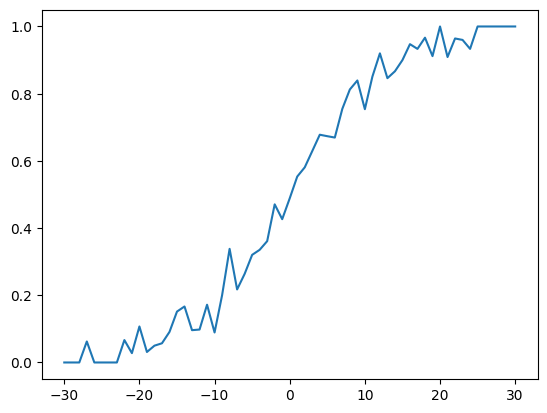

In [66]:
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0)})
plot_df["pred_int"] = plot_df["pred"].astype(int)
plot_df = plot_df.groupby('pred_int')['label'].mean().reset_index(name='average_win_pct')

plt.figure()
plt.plot(plot_df.pred_int,plot_df.average_win_pct)

In [67]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
        
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    
    print(f"logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

logloss of cvsplit 0: 0.5171054800521317
logloss of cvsplit 1: 0.5173184923561106
logloss of cvsplit 2: 0.51603377321284


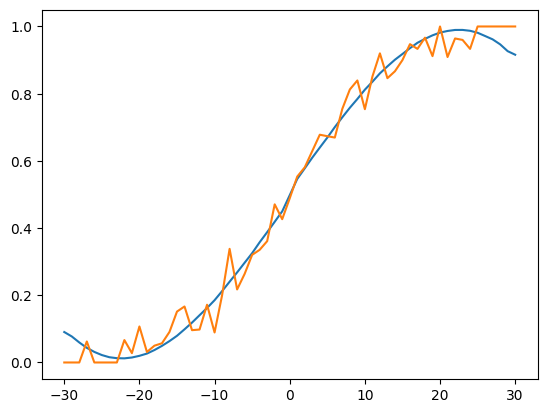

In [68]:
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0), "spline":spline_model[0](oof_preds[0])})
plot_df["pred_int"] = (plot_df["pred"]).astype(int)
plot_df = plot_df.groupby('pred_int')[['spline','label']].mean().reset_index()

plt.figure()
plt.plot(plot_df.pred_int,plot_df.spline)
plt.plot(plot_df.pred_int,plot_df.label)

In [69]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 0.5161595811724208
adjusted logloss of cvsplit 1: 0.5162865262174504
adjusted logloss of cvsplit 2: 0.5146459076011095


In [70]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16)] = 1.0
    spline_fit[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15)] = 1.0
    spline_fit[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14)] = 1.0
    spline_fit[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13)] = 1.0
    spline_fit[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1)] = 0.0
    spline_fit[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2)] = 0.0
    spline_fit[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3)] = 0.0
    spline_fit[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4)] = 0.0
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 1.07855436658169
adjusted logloss of cvsplit 1: 1.0794773548706054
adjusted logloss of cvsplit 2: 1.0786997739010475


In [71]:
#looking for upsets
pd.concat(
    [tourney_data[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13) & (tourney_data.T1_Score < tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score > tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2) & (tourney_data.T1_Score > tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3) & (tourney_data.T1_Score > tourney_data.T2_Score)],
     tourney_data[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4) & (tourney_data.T1_Score > tourney_data.T2_Score)]]
)   

#https://en.wikipedia.org/wiki/NCAA_Division_I_Women%27s_Basketball_Tournament_upsets

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d,T1_quality,T2_quality,T1_seed,T2_seed,Seed_diff
3156,2018,137,1438,54,1420,74,25.000000,54.181818,7.363636,18.878788,8.393939,13.727273,8.575758,6.787879,14.060606,18.818182,50.151515,6.151515,20.303030,8.393939,8.848485,12.727273,3.878788,2.636364,14.151515,25.612903,58.451613,9.838710,25.774194,9.709677,14.870968,11.677419,7.387097,16.516129,25.322581,56.612903,8.322581,23.161290,9.935484,13.580645,14.322581,6.258065,2.806452,1.516129,1.000000,1.000000,2.311823e+15,-4.078100e+15,1,16,-15
3413,2023,137,1345,58,1192,63,25.441176,55.382353,6.882353,21.088235,11.029412,15.500000,10.411765,4.794118,13.705882,24.058824,57.705882,6.411765,20.411765,6.323529,12.382353,9.088235,6.000000,2.941176,10.352941,27.781250,61.593750,7.843750,22.781250,9.875000,14.312500,11.156250,7.437500,19.125000,26.656250,55.062500,8.156250,22.093750,7.687500,15.031250,14.187500,5.593750,3.875000,0.312500,1.000000,0.666667,1.003072e+15,-6.703706e+15,1,16,-15
2747,2012,137,1181,70,1250,75,25.757576,56.272727,8.121212,21.606061,11.909091,12.454545,12.181818,6.242424,18.181818,25.515152,58.909091,4.454545,14.060606,11.696970,11.151515,12.909091,5.666667,2.666667,9.060606,25.750000,57.812500,7.406250,20.875000,10.843750,13.000000,11.531250,7.812500,17.781250,23.187500,55.562500,5.968750,17.906250,10.218750,13.062500,14.687500,5.687500,3.843750,10.218750,0.500000,1.000000,9.363674e+14,-2.494425e+15,2,15,-13
2750,2012,137,1281,84,1313,86,28.000000,55.588235,8.235294,20.823529,9.176471,16.205882,10.294118,8.205882,14.117647,24.617647,55.794118,6.235294,17.205882,10.764706,12.823529,14.411765,5.264706,2.647059,14.558824,24.312500,54.281250,5.343750,17.031250,11.187500,12.000000,14.812500,6.531250,19.093750,23.375000,57.687500,5.625000,18.468750,12.281250,11.093750,13.656250,6.593750,3.125000,2.812500,1.000000,1.000000,8.424736e+14,-4.350357e+15,2,15,-13
2810,2013,137,1207,68,1195,78,23.000000,50.419355,5.870968,16.419355,9.225806,14.806452,12.677419,7.548387,16.870968,19.419355,51.612903,5.354839,17.580645,10.806452,10.903226,14.225806,6.354839,3.290323,8.838710,26.218750,57.500000,6.625000,20.031250,11.687500,13.718750,14.656250,8.812500,17.593750,23.625000,57.468750,6.875000,21.843750,12.000000,13.281250,15.656250,6.937500,3.031250,5.031250,0.500000,1.000000,-1.498659e+15,-3.184150e+15,2,15,-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1125,2021,137,1317,78,1345,69,25.080000,53.280000,7.400000,19.840000,7.280000,13.040000,12.560000,6.840000,5.520000,21.320000,52.920000,5.720000,18.120000,7.720000,9.160000,13.520000,6.480000,2.960000,7.640000,25.518519,56.555556,7.111111,21.222222,9.666667,14.296296,11.888889,5.185185,4.481481,23.333333,56.333333,8.111111,25.740741,7.407407,14.074074,10.703704,5.592593,3.444444,4.814815,0.666667,0.666667,-3.026950e+15,2.483208e+15,13,4,9
1146,2021,138,1325,62,1438,58,29.545455,60.681818,8.590909,23.500000,8.500000,17.636364,11.545455,6.636364,4.136364,25.954545,58.454545,7.863636,23.363636,8.000000,13.681818,14.136364,5.636364,2.409091,7.045455,25.333333,52.750000,8.500000,22.291667,5.541667,13.958333,8.583333,4.916667,3.375000,22.041667,53.000000,6.708333,19.708333,5.875000,11.625000,8.625000,5.125000

In [72]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 0.4921034402759322
adjusted logloss of cvsplit 1: 0.4926389595695915
adjusted logloss of cvsplit 2: 0.4915641585975424


In [73]:
val_cv = []
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    
    val_cv.append(pd.DataFrame({"y":np.where(y>0,1,0), "pred":spline_fit, "season":tourney_data.Season}))
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 
    
val_cv = pd.concat(val_cv)
val_cv.groupby('season').apply(lambda x: log_loss(x.y, x.pred))

adjusted logloss of cvsplit 0: 0.4921034402759322
adjusted logloss of cvsplit 1: 0.4926389595695915
adjusted logloss of cvsplit 2: 0.4915641585975424


C:\Users\charl\AppData\Local\Temp\ipykernel_30052\1651078057.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  val_cv.groupby('season').apply(lambda x: log_loss(x.y, x.pred))


season
2003    0.514691
2004    0.484011
2005    0.489112
2006    0.550718
2007    0.421561
2008    0.453944
2009    0.459232
2010    0.463472
2011    0.485249
2012    0.487539
2013    0.510000
2014    0.482908
2015    0.423089
2016    0.544614
2017    0.476476
2018    0.532350
2019    0.430469
2021    0.523461
2022    0.541455
2023    0.528366
dtype: float64

# Submission time!

In [74]:
"""
sub["Season"] = 2018
sub["T1_TeamID"] = sub["ID"].apply(lambda x: x[5:9]).astype(int)
sub["T2_TeamID"] = sub["ID"].apply(lambda x: x[10:14]).astype(int)
sub.head()
"""
sub = pd.read_csv(DATA_PATH + "sample_submission.csv")
sub['Season'] = sub['ID'].apply(lambda x: int(x.split('_')[0]))
sub["T1_TeamID"] = sub['ID'].apply(lambda x: int(x.split('_')[1]))
sub["T2_TeamID"] = sub['ID'].apply(lambda x: int(x.split('_')[2]))
sub.head()


KeyError: 'ID'

In [75]:
sub

,RowId,Tournament,Bracket,Slot,Team
0,0,M,1,R1W1,W01
1,1,M,1,R1W8,W08
2,2,M,1,R1W5,W05
3,3,M,1,R1W4,W04
4,4,M,1,R1W6,W06
...,...,...,...,...,...
121,121,W,1,R4Y1,Y01
122,122,W,1,R4Z1,Z01
123,123,W,1,R5WX,W01
124,124,W,1,R5YZ,Y01


In [66]:
sub = pd.merge(sub, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
sub = pd.merge(sub, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')

sub = pd.merge(sub, glm_quality_T1, on = ['Season', 'T1_TeamID'], how = 'left')

sub = pd.merge(sub, glm_quality_T2, on = ['Season', 'T2_TeamID'], how = 'left')

sub = pd.merge(sub, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
sub = pd.merge(sub, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')
sub = pd.merge(sub, last14days_stats_T1, on = ['Season', 'T1_TeamID'], how = 'left')
sub = pd.merge(sub, last14days_stats_T2, on = ['Season', 'T2_TeamID'], how = 'left')

sub["Seed_diff"] = sub["T1_seed"] - sub["T2_seed"]

sub.head()

,ID,Pred,Season,T1_TeamID,T2_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T1_quality,T2_quality,T1_seed,T2_seed,T1_win_ratio_14d,T2_win_ratio_14d,Seed_diff
0,2023_1101_1102,0.5,2023,1101,1102,25.384615,58.346154,6.692308,19.5,7.615385,14.769231,11.846154,7.961538,20.884615,25.807692,51.423077,6.576923,17.269231,7.346154,13.538462,15.769231,5.384615,3.192308,-3.692308,23.625000,51.125000,8.156250,22.906250,5.625000,15.312500,10.906250,5.750000,17.000000,23.875000,53.687500,5.187500,17.687500,7.937500,10.093750,10.687500,5.718750,3.093750,-0.125000,NaN,NaN,NaN,NaN,0.0,0.0,NaN
1,2023_1101_1103,0.5,2023,1101,1103,25.384615,58.346154,6.692308,19.5,7.615385,14.769231,11.846154,7.961538,20.884615,25.807692,51.423077,6.576923,17.269231,7.346154,13.538462,15.769231,5.384615,3.192308,-3.692308,25.387097,57.451613,8.806452,25.193548,8.387097,13.000000,10.838710,5.774194,16.193548,24.709677,56.806452,7.064516,20.096774,7.322581,11.483871,11.322581,5.709677,3.032258,5.838710,NaN,NaN,NaN,NaN,0.0,0.5,NaN
2,2023_1101_1104,0.5,2023,1101,1104,25.384615,58.346154,6.692308,19.5,7.615385,14.769231,11.846154,7.961538,20.884615,25.807692,51.423077,6.576923,17.269231,7.346154,13.538462,15.769231,5.384615,3.192308,-3.692308,27.764706,62.205882,10.058824,29.764706,11.264706,15.205882,13.588235,6.058824,18.617647,23.941176,64.382353,5.529412,19.705882,9.500000,10.000000,11.411765,7.294118,3.705882,13.676471,NaN,-7.979282e+13,NaN,1.0,0.0,0.8,NaN
3,2023_1101_1105,0.5,2023,1101,1105,25.384615,58.346154,6.692308,19.5,7.615385,14.769231,11.846154,7.961538,20.884615,25.807692,51.423077,6.576923,17.269231,7.346154,13.538462,15.769231,5.384615,3.192308,-3.692308,24.233333,56.500000,6.400000,18.466667,8.766667,12.066667,13.733333,7.500000,19.100000,23.600000,55.300000,7.466667,22.066667,9.966667,12.600000,14.166667,7.500000,3.700000,-3.066667,NaN,NaN,NaN,NaN,0.0,0.5,NaN
4,2023_1101_1106,0.5,2023,1101,1106,25.384615,58.346154,6.692308,19.5,7.615385,14.769231,11.846154,7.961538,20.884615,25.807692,51.423077,6.576923,17.269231,7.346154,13.538462,15.769231,5.384615,3.192308,-3.692308,21.800000,58.566667,5.966667,19.400000,10.300000,9.733333,12.300000,5.666667,17.866667,25.733333,58.800000,6.966667,20.400000,10.633333,11.833333,11.266667,6.733333,4.833333,-10.033333,NaN,NaN,NaN,NaN,0.0,0.0,NaN


In [67]:
Xsub = sub[features].values
dtest = xgb.DMatrix(Xsub)

In [68]:
sub_models = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    sub_models.append(
        xgb.train(
          params = param,
          dtrain = dtrain,
          num_boost_round = int(iteration_counts[i] * 1.05),
          verbose_eval = 50
        )
    )

Fold repeater 0


c:\Users\charl\Desktop\Git\tep-research\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [16:21:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


Fold repeater 1
Fold repeater 2


c:\Users\charl\Desktop\Git\tep-research\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [16:21:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


In [69]:

booster = sub_models[0]

feature_importance = booster.get_score(importance_type='weight')
mapped_feature_importance = {features[int(key[1:])]: value for key, value in feature_importance.items()}

# Display the mapped feature importance
importances = pd.DataFrame([mapped_feature_importance]).T.reset_index().rename(columns={0:'score','index':'col'})
importances.sort_values('score', ascending=False)

,col,score
42,Seed_diff,252.0
18,T1_PointDiffmean,188.0
37,T2_PointDiffmean,182.0
44,T2_quality,125.0
43,T1_quality,116.0
0,T1_FGMmean,108.0
39,T2_seed,107.0
19,T2_FGMmean,105.0
4,T1_ORmean,94.0
27,T2_PFmean,92.0


In [70]:
sub_preds = []
for i in range(repeat_cv):
    sub_preds.append(np.clip(spline_model[i](np.clip(sub_models[i].predict(dtest),-30,30)),0.025,0.975))
    
sub["Pred"] = pd.DataFrame(sub_preds).mean(axis=0)
"""
sub.loc[(sub.T1_seed==1) & (sub.T2_seed==16), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==2) & (sub.T2_seed==15), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==3) & (sub.T2_seed==14), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==4) & (sub.T2_seed==13), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==16) & (sub.T2_seed==1), 'Pred'] = 0.0
sub.loc[(sub.T1_seed==15) & (sub.T2_seed==2), 'Pred'] = 0.0
sub.loc[(sub.T1_seed==14) & (sub.T2_seed==3), 'Pred'] = 0.0
sub.loc[(sub.T1_seed==13) & (sub.T2_seed==4), 'Pred'] = 0.0
"""
sub[['ID','Pred']].to_csv("submission.csv", index = None)

In [ ]:
"""
tourney_results2018 = pd.read_csv('../input/NCAA_2018_Solution_Womens.csv')
tourney_results2018 = tourney_results2018[tourney_results2018.Pred!=-1].reset_index(drop=True)
tourney_results2018.columns = ['ID', 'label']
tourney_results2018 = pd.merge(tourney_results2018, sub, on = 'ID')
log_loss(tourney_results2018.label, tourney_results2018.Pred)
"""